## Introduction

In this notebook, we explore the creation and analysis of disease-gene and protein-protein interaction networks using the NetworkX library. We will fetch relevant datasets, construct directed and undirected graphs, and visualize disease-specific networks, with a focus on breast cancer and other diseases. By the end, we will have a comprehensive understanding of network creation and analysis methods applicable to various diseases from open target platform.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mentorchains/BI-ML_Disease-Prediction_2024/tree/dev/notebook/fetching-opentargets-and-string-database-for-creating-gene-protein-interaction-networks.ipynb)

## Table of Contents

- [Fetching Datasets](#fetching-datasets)
    - [Open Target Dataset (Breast Cancer)](#open-target-dataset)
    - [STRING Database](#string-database)

- [Graph Creation and Visualization with NetworkX](#graph-creation-and-visualization-with-networkx)
    - [Tutorial: Directed and Undirected Graphs](#tutorial-directed-and-undirected-graphs)
        - [Creating Directed Graphs](#creating-directed-graphs)
        - [Creating Undirected Graphs](#creating-undirected-graphs)
    - [Detecting Communities in Graphs](#detecting-communities-in-graphs)

- [Disease-Specific Graph Construction](#disease-specific-graph-construction)
    - [Building Breast Cancer Interaction Networks](#building-breast-cancer-interaction-networks)
        - [Method 1: Using `from_pandas_edgelist` and `compose`](#method-1-using-from_pandas_edgelist-and-compose)
        - [Method 2: Manually Adding Edges with `add_edge` and `compose`](#method-2-manually-adding-edges-with-add_edge-and-compose)
        - [Comparing Node Connections Across Methods](#comparing-node-connections-across-methods)

- [Integrating Graphs and Class Definitions](#integrating-graphs-and-class-definitions)
    - [Generating Graphs for Infectious Diseases](#generating-graphs-for-infectious-diseases)
    - [Generating Graphs for Alzheimer’s Disease](#generating-graphs-for-alzheimers-disease)


We need to get the [Open Targets](https://platform.opentargets.org/) disease data and then get the [STRING Database](https://string-db.org/cgi/download) for Protein-Protein Interaction (PPI)

We can either download the data manually, but we'll use the GraphQL API and STRING API as they’re the fastest options to retrieve them

In [1]:
import requests
import json
from pprint import pprint
import pandas as pd
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt

## Fetching Datasets

### Open Target Dataset

_Query Sourced from [here](https://youtu.be/_sZR0VxpwqE?si=2woc8GEd7uV-_vD4&t=1240) and [here](https://docs.google.com/presentation/d/16_99z8Su8j8HbFuhxSlTRZZCW67hNpk0To7UfpoeiTg/edit#slide=id.ged447725a9_0_181)_

In [2]:
query = """
  query DiseaseAssociationsQuery($efoId: String!){
  disease(efoId: $efoId){
    id
    name
    associatedTargets{
      count
      rows{
        target{
          id
          approvedSymbol
        }
        score
        datasourceScores {
          id
          score
        }
      }
    }
  }
}
"""

In [3]:
def fetch_graphql_data(disease_id):
    """
    Fetch data from a GraphQL API endpoint.
    """
    # Set variables
    variables = {"efoId": disease_id}

    # Set base URL of GraphQL API endpoint
    base_url = "https://api.platform.opentargets.org/api/v4/graphql"

    # Perform POST request and check status code of response
    response = requests.post(base_url, json={"query": query, "variables": variables})
    if response.status_code == 200:
        print("request was successful\n")

    # transform API response from JSON into Python dict
    api_res = json.loads(response.text)
    pprint(api_res)

    return api_res

Let's fetch the [Breast Cancer](https://platform.opentargets.org/disease/MONDO_0007254/associations) dataset. The EFO ID for Breast Cancer is `MONDO_0007254`

In [4]:
disease_id = "MONDO_0007254" # you can find it at the top left of the open targets platform
api_res = fetch_graphql_data(disease_id)

request was successful

{'data': {'disease': {'associatedTargets': {'count': 11908,
                                            'rows': [{'datasourceScores': [{'id': 'uniprot_variants',
                                                                            'score': 0.9967809897717167},
                                                                           {'id': 'gene_burden',
                                                                            'score': 0.981427193451389},
                                                                           {'id': 'genomics_england',
                                                                            'score': 0.9779019396789099},
                                                                           {'id': 'eva',
                                                                            'score': 0.9699325219179143},
                                                                           {'id': 'eva_somatic',
      

In [5]:
# extract relevant data
associated_targets = api_res['data']['disease']['associatedTargets']['rows']

# normalize the JSON data
open_target_df = pd.json_normalize(
    data=associated_targets,
    record_path='datasourceScores',      # the path to the records to flatten
    meta=['target', 'score'],            # the fields to extract from the parent record
    record_prefix='datasourceScores_',   # Prefix for fields from the records
    errors='ignore'
)

# further normalize the nested target column
target_df = pd.json_normalize(open_target_df['target'])
open_target_df = open_target_df.drop(columns=['target'])
open_target_df = pd.concat([open_target_df, target_df], axis=1)

open_target_df.head()

datasourceScores_id  datasourceScores_score     score               id  \
0    uniprot_variants                0.996781  0.924615  ENSG00000139618   
1         gene_burden                0.981427  0.924615  ENSG00000139618   
2    genomics_england                0.977902  0.924615  ENSG00000139618   
3                 eva                0.969933  0.924615  ENSG00000139618   
4         eva_somatic                0.948894  0.924615  ENSG00000139618   

  approvedSymbol  
0          BRCA2  
1          BRCA2  
2          BRCA2  
3          BRCA2  
4          BRCA2

In [6]:
agg_df = open_target_df.groupby('id').agg({
    'approvedSymbol': 'first',
    'score': 'mean'
}).reset_index()

agg_df.head()

id approvedSymbol     score
0  ENSG00000012048          BRCA1  0.921231
1  ENSG00000039068           CDH1  0.825421
2  ENSG00000062822          POLD1  0.752919
3  ENSG00000083093          PALB2  0.867268
4  ENSG00000091831           ESR1  0.857948

In [7]:
# Aggregate by ID
agg_df = open_target_df.groupby('id').agg({
    'approvedSymbol': 'first',
    'score': 'mean',
    'datasourceScores_id': lambda x: list(x),    # aggregate into a list
    'datasourceScores_score': lambda x: list(x)  # aggregate into a list
}).reset_index()

agg_df.head()


id approvedSymbol     score  \
0  ENSG00000012048          BRCA1  0.921231   
1  ENSG00000039068           CDH1  0.825421   
2  ENSG00000062822          POLD1  0.752919   
3  ENSG00000083093          PALB2  0.867268   
4  ENSG00000091831           ESR1  0.857948   

                                 datasourceScores_id  \
0  [uniprot_variants, eva, gene_burden, eva_somat...   
1  [cancer_gene_census, intogen, eva, eva_somatic...   
2  [chembl, cancer_gene_census, slapenrich, intog...   
3  [eva, gene_burden, genomics_england, cancer_ge...   
4  [chembl, cancer_gene_census, ot_genetics_porta...   

                              datasourceScores_score  
0  [0.9967809897717167, 0.9699027100268988, 0.961...  
1  [0.9470005150013617, 0.9334985585431808, 0.931...  
2  [0.9769980215991244, 0.7001778390862753, 0.833...  
3  [0.9685600208209743, 0.9518332216356467, 0.919...  
4  [0.9954471784803182, 0.9226214066290276, 0.807...

In [8]:
# These are the gene symbols associated with breast cancer disease
gene_symbols = agg_df['approvedSymbol'].tolist()
gene_symbols

['BRCA1',
 'CDH1',
 'POLD1',
 'PALB2',
 'ESR1',
 'MAP3K1',
 'CDK6',
 'GATA3',
 'RAD51C',
 'PIK3CA',
 'TBX3',
 'CDK4',
 'BRIP1',
 'BARD1',
 'BRCA2',
 'TP53',
 'ERBB2',
 'AKT1',
 'EGFR',
 'ATM',
 'PTEN',
 'POLE',
 'ERBB4',
 'CHEK2',
 'RAD51D']

In [9]:
# and these are the unique features associated with the gene symbols
features = []
for feature_list in agg_df['datasourceScores_id'].tolist():
    for feature in feature_list:
        if feature not in features:
            features.append(feature)

features


['uniprot_variants',
 'eva',
 'gene_burden',
 'eva_somatic',
 'genomics_england',
 'cancer_gene_census',
 'uniprot_literature',
 'orphanet',
 'clingen',
 'intogen',
 'slapenrich',
 'cancer_biomarkers',
 'europepmc',
 'impc',
 'chembl',
 'ot_genetics_portal',
 'crispr',
 'progeny',
 'gene2phenotype',
 'reactome']

In [10]:
def get_feature_score(df, gene_symbol, feature_key):
    """
    Filters the DataFrame for a given gene symbol and 
    retrieves the score for the specified feature.
    """
    gene_df = df[df['approvedSymbol'] == gene_symbol]
    if gene_df.empty:
        raise ValueError(f"No features found for the gene symbol: {gene_symbol}")

    score = None
    
    for _, row in gene_df.iterrows():
        if feature_key in row['datasourceScores_id']:
            if isinstance(row['datasourceScores_score'], float):
                score = row['datasourceScores_score']
            else:
                index = row['datasourceScores_id'].index(feature_key)
                score = row['datasourceScores_score'][index]
            break

    if score is None:
        raise ValueError(f"Feature key '{feature_key}' not found for gene symbol: {gene_symbol}")
    
    print(f"{feature_key} score for {gene_symbol}: {score}")

    return score


In [11]:
# reference the (x1, y1) coordinates in the platform, as shown in the attached screenshot
score = get_feature_score(agg_df,"BRCA2", "ot_genetics_portal")

ot_genetics_portal score for BRCA2: 0.3249228882691419


![screenshot](https://github.com/user-attachments/assets/e53d746b-98ed-4a39-b89b-6e0a606568f4)

### STRING Database

_source code used can be found here [Getting String Network Interactions](https://string-db.org/help//api/#getting-the-string-network-interactions)_

`https://string-db.org/api/[output-format]/network?identifiers=[your_identifiers]&[optional_parameters]`

For the latter ML network, we can use this [all partners of protein set](https://string-db.org/help//api/#getting-all-the-string-interaction-partners-of-the-protein-set)


In [12]:
def fetch_string_data(my_genes, caller_identity="app.name"):
    """
    Fetches data from the STRING API based on provided gene symbols
    """
    string_api_url = "https://version-11-5.string-db.org/api"
    output_format = "json"
    method = "network"

    ## Construct URL
    request_url = "/".join([string_api_url, output_format, method])

    ## Set parameters
    params = {
        "identifiers": "%0d".join(my_genes),  # your protein
        "species": 9606, # Human taxonomy, aka Homo sapiens
        "caller_identity": caller_identity  # your app name
    }

    ## Call STRING
    try:
        res = requests.post(request_url, data=params)
        res.raise_for_status()
        data = res.json()

        return data
    
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")

        return None
    
    except json.JSONDecodeError:
        print("Failed to decode JSON response")

        return None

In [13]:
# gene symbols are from our open targets
# print (gene_symbols)
my_genes = gene_symbols
data = fetch_string_data(my_genes)

STRING_df = pd.json_normalize(data, errors='ignore')
print(STRING_df.columns)
print(STRING_df.shape)


Index(['stringId_A', 'stringId_B', 'preferredName_A', 'preferredName_B',
       'ncbiTaxonId', 'score', 'nscore', 'fscore', 'pscore', 'ascore',
       'escore', 'dscore', 'tscore'],
      dtype='object')
(396, 13)


| Field            | Description                             |
|------------------|-----------------------------------------|
| stringId_A       | STRING identifier (protein A)           |
| stringId_B       | STRING identifier (protein B)           |
| preferredName_A  | common protein name (protein A)         |
| preferredName_B  | common protein name (protein B)         |
| ncbiTaxonId      | NCBI taxon identifier                   |
| score            | combined score                           |
| nscore           | gene neighborhood score                  |
| fscore           | gene fusion score                        |
| pscore           | phylogenetic profile score               |
| ascore           | coexpression score                       |
| escore           | experimental score                       |
| dscore           | database score                           |
| tscore           | textmining score                         |


In [14]:
STRING_df.head()

stringId_A            stringId_B preferredName_A preferredName_B  \
0  9606.ENSP00000257566  9606.ENSP00000269305            TBX3            TP53   
1  9606.ENSP00000257566  9606.ENSP00000269305            TBX3            TP53   
2  9606.ENSP00000257566  9606.ENSP00000261769            TBX3            CDH1   
3  9606.ENSP00000257566  9606.ENSP00000261769            TBX3            CDH1   
4  9606.ENSP00000257566  9606.ENSP00000382423            TBX3          MAP3K1   

  ncbiTaxonId  score  nscore  fscore  pscore  ascore  escore  dscore  tscore  
0        9606  0.400     0.0       0     0.0   0.000   0.000     0.0   0.400  
1        9606  0.400     0.0       0     0.0   0.000   0.000     0.0   0.400  
2        9606  0.425     0.0       0     0.0   0.062   0.000     0.0   0.413  
3        9606  0.425     0.0       0     0.0   0.062   0.000     0.0   0.413  
4        9606  0.468     0.0       0     0.0   0.000   0.065     0.0   0.455

In [15]:
STRING_df.dtypes

stringId_A          object
stringId_B          object
preferredName_A     object
preferredName_B     object
ncbiTaxonId         object
score              float64
nscore             float64
fscore               int64
pscore             float64
ascore             float64
escore             float64
dscore             float64
tscore             float64
dtype: object

In [16]:
df_filtered = STRING_df[STRING_df['escore'] > 0.4]
df_sorted = df_filtered.sort_values(by='escore', ascending=False)
df_sorted[['preferredName_A', 'preferredName_B', 'escore', 'score']].head()

preferredName_A preferredName_B  escore  score
91            BARD1           BRCA1   0.998  0.999
90            BARD1           BRCA1   0.998  0.999
252           ERBB2            EGFR   0.982  0.998
253           ERBB2            EGFR   0.982  0.998
120           PALB2           BRCA2   0.981  0.999

In [17]:
# fast overlap check for the BRCA1 gene
gene = 'BRCA1'

openTarget = open_target_df[open_target_df['approvedSymbol'] == gene]
openTarget.head()

datasourceScores_id  datasourceScores_score     score               id  \
15    uniprot_variants                0.996781  0.921231  ENSG00000012048   
16                 eva                0.969903  0.921231  ENSG00000012048   
17         gene_burden                0.961542  0.921231  ENSG00000012048   
18         eva_somatic                0.955114  0.921231  ENSG00000012048   
19    genomics_england                0.947176  0.921231  ENSG00000012048   

   approvedSymbol  
15          BRCA1  
16          BRCA1  
17          BRCA1  
18          BRCA1  
19          BRCA1

In [18]:
StringDB = STRING_df[STRING_df['preferredName_A'] == gene]
StringDB.head()

stringId_A            stringId_B preferredName_A  \
392  9606.ENSP00000418960  9606.ENSP00000466399           BRCA1   
393  9606.ENSP00000418960  9606.ENSP00000466399           BRCA1   
394  9606.ENSP00000418960  9606.ENSP00000451828           BRCA1   
395  9606.ENSP00000418960  9606.ENSP00000451828           BRCA1   

    preferredName_B ncbiTaxonId  score  nscore  fscore  pscore  ascore  \
392          RAD51D        9606  0.825     0.0       0     0.0   0.126   
393          RAD51D        9606  0.825     0.0       0     0.0   0.126   
394            AKT1        9606  0.987     0.0       0     0.0   0.000   
395            AKT1        9606  0.987     0.0       0     0.0   0.000   

     escore  dscore  tscore  
392   0.095     0.0   0.797  
393   0.095     0.0   0.797  
394   0.835     0.8   0.657  
395   0.835     0.8   0.657

In [19]:
StringDB2 = STRING_df[STRING_df['preferredName_B'] == gene]
StringDB2.head()

stringId_A            stringId_B preferredName_A  \
44  9606.ENSP00000257904  9606.ENSP00000418960            CDK4   
45  9606.ENSP00000257904  9606.ENSP00000418960            CDK4   
66  9606.ENSP00000259008  9606.ENSP00000418960           BRIP1   
67  9606.ENSP00000259008  9606.ENSP00000418960           BRIP1   
90  9606.ENSP00000260947  9606.ENSP00000418960           BARD1   

   preferredName_B ncbiTaxonId  score  nscore  fscore  pscore  ascore  escore  \
44           BRCA1        9606  0.973     0.0       0     0.0   0.088   0.675   
45           BRCA1        9606  0.973     0.0       0     0.0   0.088   0.675   
66           BRCA1        9606  0.999     0.0       0     0.0   0.212   0.981   
67           BRCA1        9606  0.999     0.0       0     0.0   0.212   0.981   
90           BRCA1        9606  0.999     0.0       0     0.0   0.161   0.998   

    dscore  tscore  
44     0.8   0.604  
45     0.8   0.604  
66     0.8   0.989  
67     0.8   0.989  
90     0.9   0.992

## Graph Creation and Visualization with NetworkX

Creating Disease-Gene & Protein-Protein Interaction Network Graphs using Networkx

### Tutorial: Directed and Undirected Graphs

in Networkx, there are two types of graphs, directed graphs have edges with a specific direction (from node `u` to node `v`), while undirected graphs treat edges as bidirectional

#### Creating Directed Graphs

In [20]:
def plot_DiGraph(
        df: pd.DataFrame,
        source_col: str,
        target_col: str,
        edge_attr_col: str,
        figsize: tuple = (10, 8)
) -> None:
    """
    Create and plot a directed graph from the given df
    """
    # create a directed graph from the DataFrame
    DiGraph = nx.from_pandas_edgelist(
        df,
        source=source_col,
        target=target_col,
        edge_attr=edge_attr_col,
        create_using=nx.DiGraph()  # notice the DiGraph class, aka DirectGraph
    )
    
    # plot the directed graph
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(DiGraph)
    nx.draw(
        DiGraph,
        pos,
        with_labels=True,
        node_color='lightblue',
        edge_color='gray',
        node_size=3000,
        font_size=10,
        font_weight='bold',
        arrows=True
    )
    
    edge_labels = nx.get_edge_attributes(DiGraph, edge_attr_col)
    nx.draw_networkx_edge_labels(DiGraph, pos, edge_labels=edge_labels)
    plt.title(f'PPI Network ({DiGraph})')
    plt.show()
    return DiGraph

In [21]:
tut_STRING_df = STRING_df.copy()

In [22]:
# Select the first two gene symbols for the example
tut_gene = gene_symbols[0:2]
tut_gene

['BRCA1', 'CDH1']

In [23]:
# Filter the dataframe for interactions involving the selected genes
tut_STRING_df = tut_STRING_df[(tut_STRING_df['preferredName_A'].isin(tut_gene)) & 
                          (tut_STRING_df['preferredName_B'].isin(gene_symbols))]

tut_STRING_df.head()

stringId_A            stringId_B preferredName_A  \
122  9606.ENSP00000261769  9606.ENSP00000278616            CDH1   
123  9606.ENSP00000261769  9606.ENSP00000278616            CDH1   
124  9606.ENSP00000261769  9606.ENSP00000369497            CDH1   
125  9606.ENSP00000261769  9606.ENSP00000369497            CDH1   
126  9606.ENSP00000261769  9606.ENSP00000342235            CDH1   

    preferredName_B ncbiTaxonId  score  nscore  fscore  pscore  ascore  \
122             ATM        9606  0.459     0.0       0     0.0     0.0   
123             ATM        9606  0.459     0.0       0     0.0     0.0   
124           BRCA2        9606  0.470     0.0       0     0.0     0.0   
125           BRCA2        9606  0.470     0.0       0     0.0     0.0   
126           ERBB4        9606  0.489     0.0       0     0.0     0.0   

     escore  dscore  tscore  
122   0.000     0.0   0.459  
123   0.000     0.0   0.459  
124   0.000     0.0   0.470  
125   0.000     0.0   0.470  
126   0.059     0.0   0.479

- In the STRING directed Graph the arrows indicate the direction of relationships from `preferredName_A` to `preferredName_B`. The weight represents as the `score` value for each edge

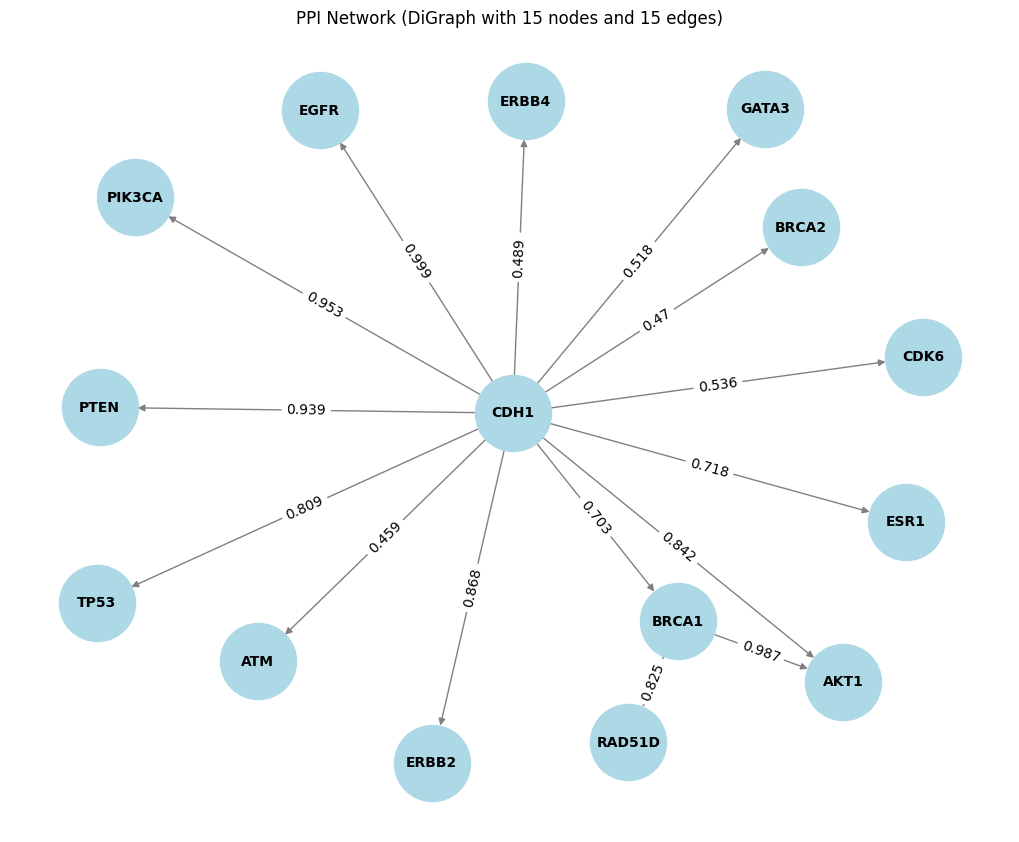

In [24]:
Tut_STRING_DiGraph = plot_DiGraph(tut_STRING_df,'preferredName_A', 'preferredName_B', 'score')

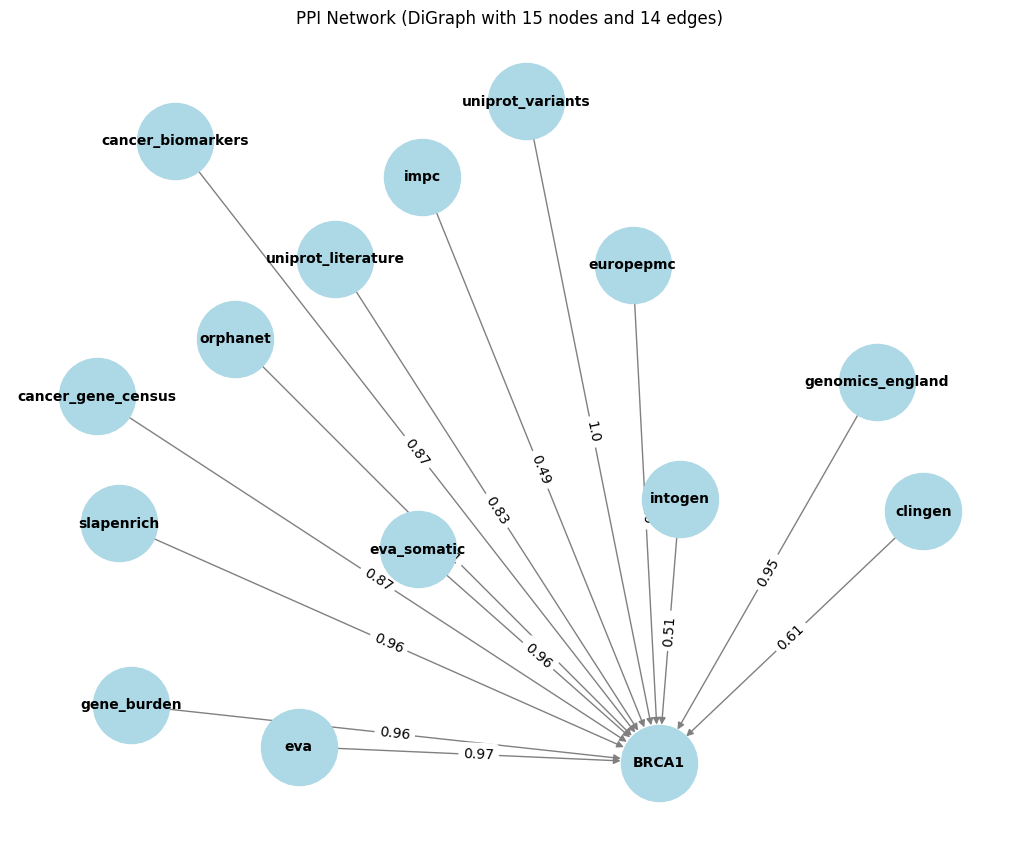

In [25]:
# similary we can see the directed graph in the open target dataset
tut_open_target_df = open_target_df.copy()
# Filter the df to include only rows with the a specific gene symbol
tut_open_target_df = tut_open_target_df[tut_open_target_df['approvedSymbol'] == 'BRCA1']
# Round the 'score' column to 2 decimal places
tut_open_target_df['datasourceScores_score'] = tut_open_target_df['datasourceScores_score'].round(2)

# plot the directed graph
Tut_open_target_DiGraph = plot_DiGraph(tut_open_target_df, 'datasourceScores_id', 'approvedSymbol', 'datasourceScores_score') 

#### Creating Undirected Graphs

- In the undirected Graph, there are no arrows because edges are bidirectional. The weight (scores) remains unchanged, and edge direction is not considered

In [26]:
def plot_Graph(
        df: pd.DataFrame,
        source_col: str,
        target_col: str,
        edge_attr_col: str,
        figsize: tuple = (10, 8)
) -> None:
    """
    Create and plot a undirected graph from the given df
    """
    # create a undirected graph from the DataFrame
    G = nx.from_pandas_edgelist(
        df,
        source=source_col,
        target=target_col,
        edge_attr=edge_attr_col,
        create_using=nx.Graph()  # notice the undirect Graph
    )
    
    # plot the undirected graph
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G)
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color='lightgreen',
        edge_color='gray',
        node_size=3000,
        font_size=10,
        font_weight='bold',
        arrows=True
    )
    
    edge_labels = nx.get_edge_attributes(G, edge_attr_col)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(f'PPI Network ({G})')
    plt.show()
    return G

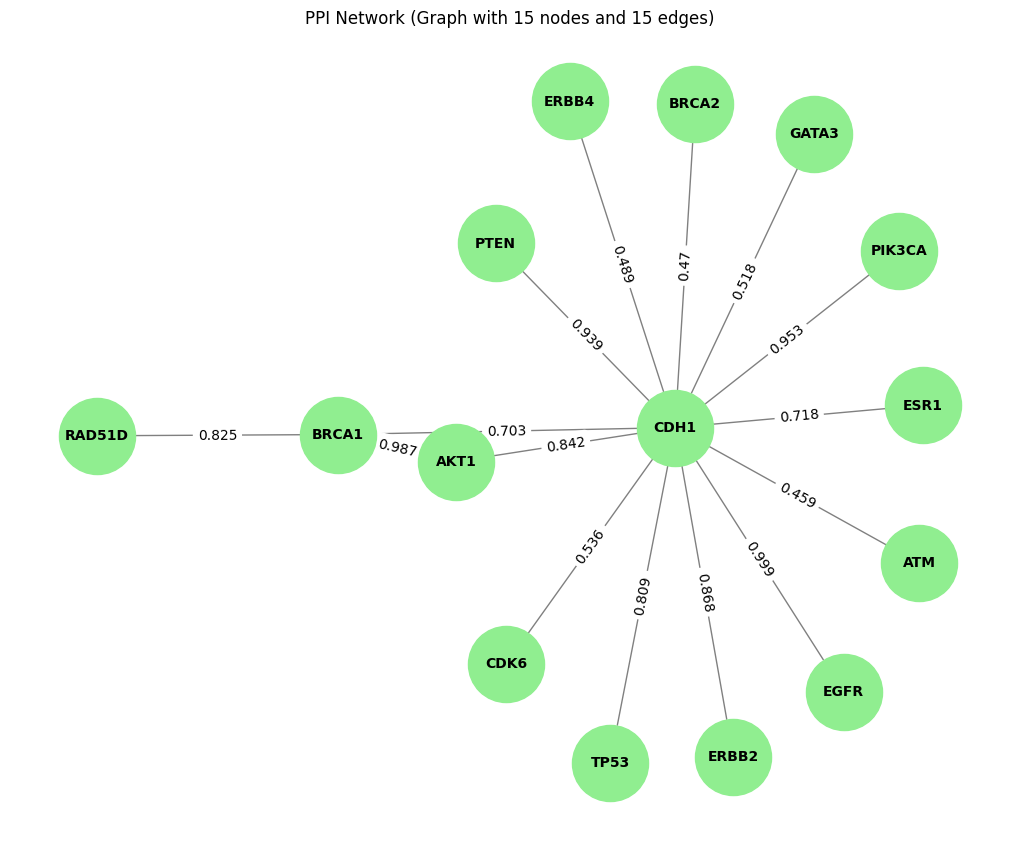

In [27]:
Tut_STRING_Graph = plot_Graph(tut_STRING_df,'preferredName_A', 'preferredName_B', 'score')

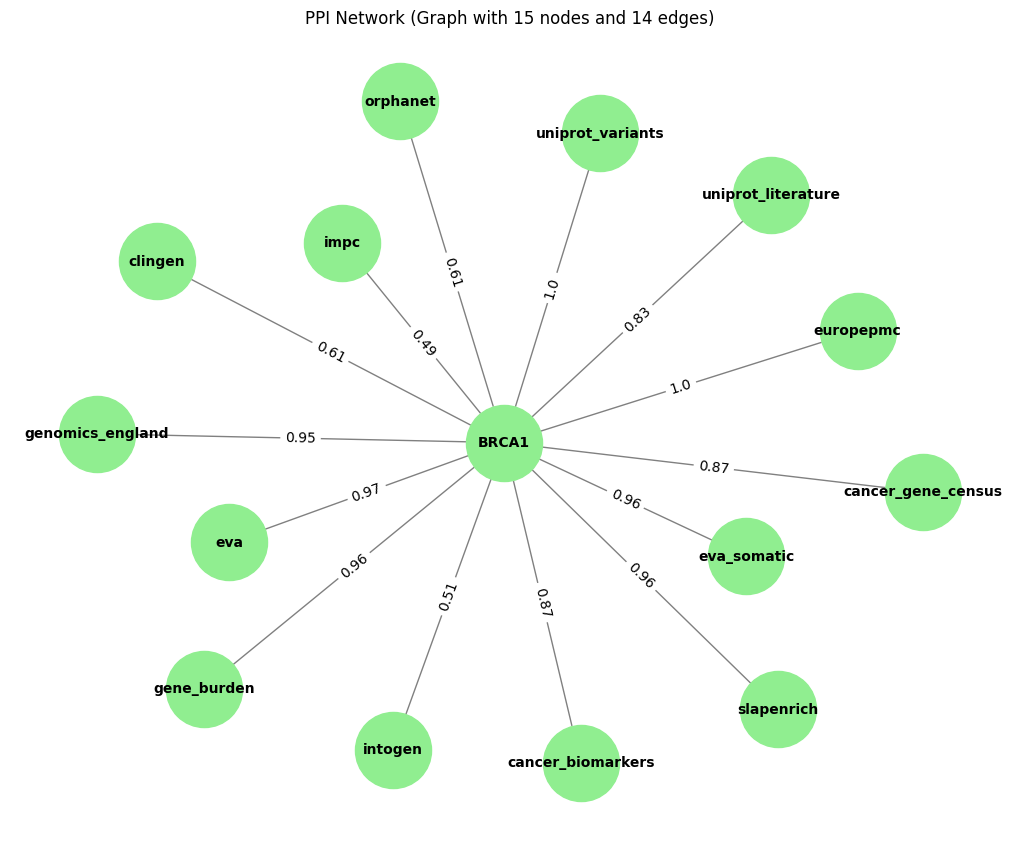

In [28]:
Tut_open_target_Graph = plot_Graph(tut_open_target_df, 'datasourceScores_id', 'approvedSymbol', 'datasourceScores_score')

#### Which Graph we chose?

For a general PPI networks where interactions are typically mutual and direction is not that important, we use an undirected graph, as it's the common choice for most PPI studies. However, if we ever need to direct these graphs, we now know where to look

### Detecting Communities in Graphs

- Community detection identifies groups of nodes in a graph that are more connected to each other than to the rest of the network
- Each community is assigned a distinct color, so nodes in the same community (cluster) share the same color
- Colors help to easily visualize and distinguish different communities (clusters) within the network

In [29]:
def plot_community_detection(graph, edge_attr_col: str, figsize: tuple = (10, 8))-> None:
    """
    plots graph with community detection
    """
    communities = community.greedy_modularity_communities(graph)

    # Color nodes by community
    colors = [0] * graph.number_of_nodes()
    for i, comm in enumerate(communities):
        for node in comm:
            colors[list(graph.nodes()).index(node)] = i

    # Plotting
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(graph)
    nx.draw(
        graph,
        pos, with_labels=True,
        node_color=colors,
        cmap=plt.cm.jet, node_size=1000, edge_color='gray', arrows=True
    )
    edge_labels = nx.get_edge_attributes(graph, edge_attr_col)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    plt.title(f'PPI Network with Communities ({graph})')
    plt.show()

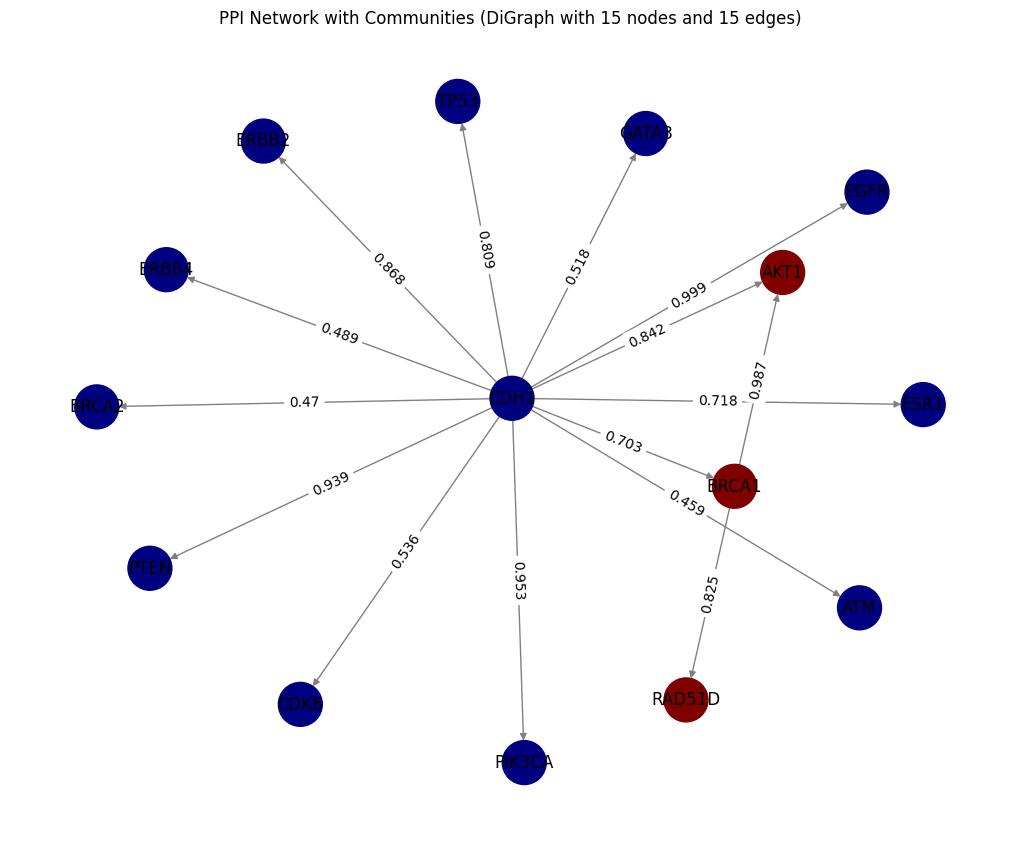

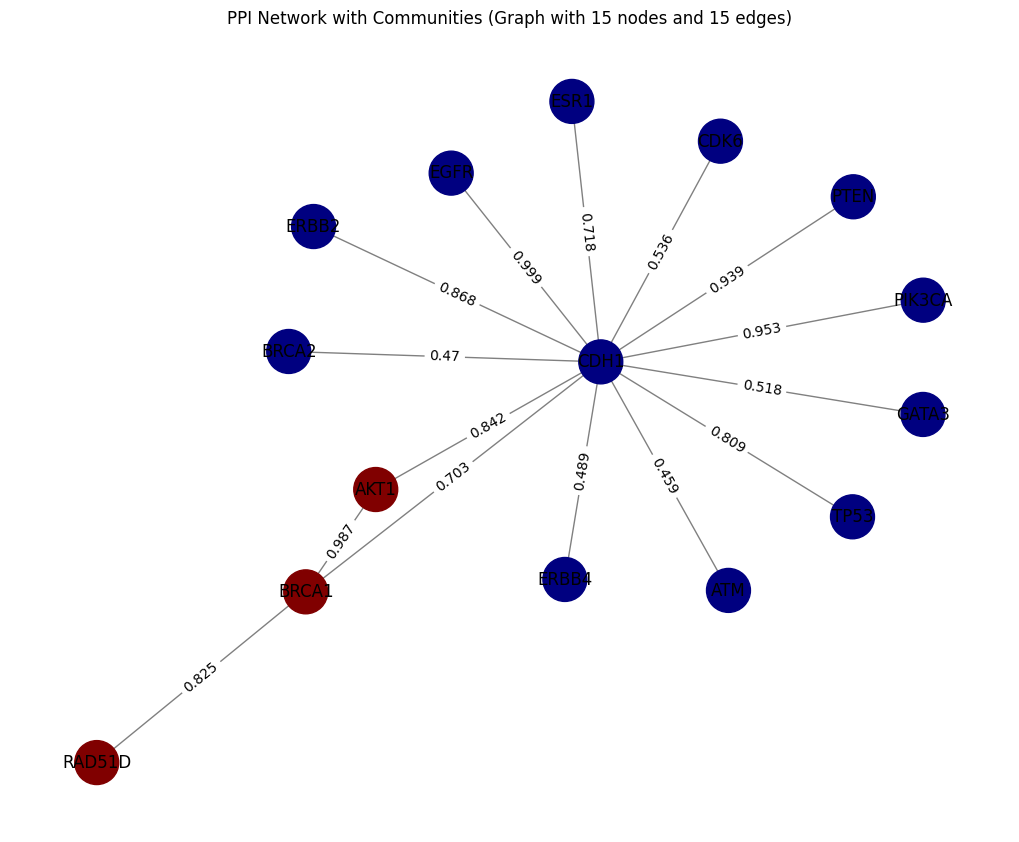

In [30]:
plot_community_detection(Tut_STRING_DiGraph, edge_attr_col ='score')
plot_community_detection(Tut_STRING_Graph, edge_attr_col = 'score')

## Disease-Specific Graph Construction

### Building Breast Cancer Interaction Networks

we already fetched the breast cancer dataset in this [section](#open-target-dataset)

In [31]:
# breast cancer dataset
open_target_df

datasourceScores_id  datasourceScores_score     score               id  \
0      uniprot_variants                0.996781  0.924615  ENSG00000139618   
1           gene_burden                0.981427  0.924615  ENSG00000139618   
2      genomics_england                0.977902  0.924615  ENSG00000139618   
3                   eva                0.969933  0.924615  ENSG00000139618   
4           eva_somatic                0.948894  0.924615  ENSG00000139618   
..                  ...                     ...       ...              ...   
209              chembl                0.976998  0.740814  ENSG00000177084   
210  cancer_gene_census                0.705094  0.740814  ENSG00000177084   
211          slapenrich                0.833427  0.740814  ENSG00000177084   
212                 eva                0.278570  0.740814  ENSG00000177084   
213           europepmc                0.199886  0.740814  ENSG00000177084   

    approvedSymbol  
0            BRCA2  
1            BRCA2  
2            BRCA2  
3            BRCA2  
4            BRCA2  
..             ...  
209           POLE  
210           POLE  
211           POLE  
212           POLE  
213           POLE  

[214 rows x 5 columns]

In [32]:
open_target_df['datasourceScores_score'] = open_target_df['datasourceScores_score'].round(3)

In [33]:
STRING_df

stringId_A            stringId_B preferredName_A  \
0    9606.ENSP00000257566  9606.ENSP00000269305            TBX3   
1    9606.ENSP00000257566  9606.ENSP00000269305            TBX3   
2    9606.ENSP00000257566  9606.ENSP00000261769            TBX3   
3    9606.ENSP00000257566  9606.ENSP00000261769            TBX3   
4    9606.ENSP00000257566  9606.ENSP00000382423            TBX3   
..                    ...                   ...             ...   
391  9606.ENSP00000406046  9606.ENSP00000418960           POLD1   
392  9606.ENSP00000418960  9606.ENSP00000466399           BRCA1   
393  9606.ENSP00000418960  9606.ENSP00000466399           BRCA1   
394  9606.ENSP00000418960  9606.ENSP00000451828           BRCA1   
395  9606.ENSP00000418960  9606.ENSP00000451828           BRCA1   

    preferredName_B ncbiTaxonId  score  nscore  fscore  pscore  ascore  \
0              TP53        9606  0.400     0.0       0     0.0   0.000   
1              TP53        9606  0.400     0.0       0     0.0   0.000   
2              CDH1        9606  0.425     0.0       0     0.0   0.062   
3              CDH1        9606  0.425     0.0       0     0.0   0.062   
4            MAP3K1        9606  0.468     0.0       0     0.0   0.000   
..              ...         ...    ...     ...     ...     ...     ...   
391           BRCA1        9606  0.978     0.0       0     0.0   0.198   
392          RAD51D        9606  0.825     0.0       0     0.0   0.126   
393          RAD51D        9606  0.825     0.0       0     0.0   0.126   
394            AKT1        9606  0.987     0.0       0     0.0   0.000   
395            AKT1        9606  0.987     0.0       0     0.0   0.000   

     escore  dscore  tscore  
0     0.000     0.0   0.400  
1     0.000     0.0   0.400  
2     0.000     0.0   0.413  
3     0.000     0.0   0.413  
4     0.065     0.0   0.455  
..      ...     ...     ...  
391   0.391     0.9   0.613  
392   0.095     0.0   0.797  
393   0.095     0.0   0.797  
394   0.835     0.8   0.657  
395   0.835     0.8   0.657  

[396 rows x 13 columns]

### Method 1: Using [from_pandas_edgelist](https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html#from-pandas-edgelist) and [compose](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.operators.binary.compose.html#compose)

In [34]:
# create a graph for open target data
G = nx.from_pandas_edgelist(
    open_target_df, 
    source='datasourceScores_id', 
    target='approvedSymbol',
    edge_attr='datasourceScores_score',
    # edge_attr=['datasourceScores_score', 'score'], 
    create_using=nx.Graph()
)

for u, v, data in G.edges(data=True):
    data['weight'] = data.pop('datasourceScores_score')  # Assign weight
    data['type'] = 'disease-gene'

In [35]:
# Create a graph for the STRING dataframe
H = nx.from_pandas_edgelist(
    STRING_df, 
    source='preferredName_A', 
    target='preferredName_B', 
    edge_attr='score',
    # edge_attr=['score', 'nscore', 'fscore', 'pscore', 'ascore', 'escore', 'dscore', 'tscore'],
    create_using=nx.Graph()
)

for u, v, data in H.edges(data=True):
    data['weight'] = data.pop('score') # Assign weight
    data['type'] = 'protein-protein'

In [36]:
# Merge the two graphs
G_composed = nx.compose(G, H)

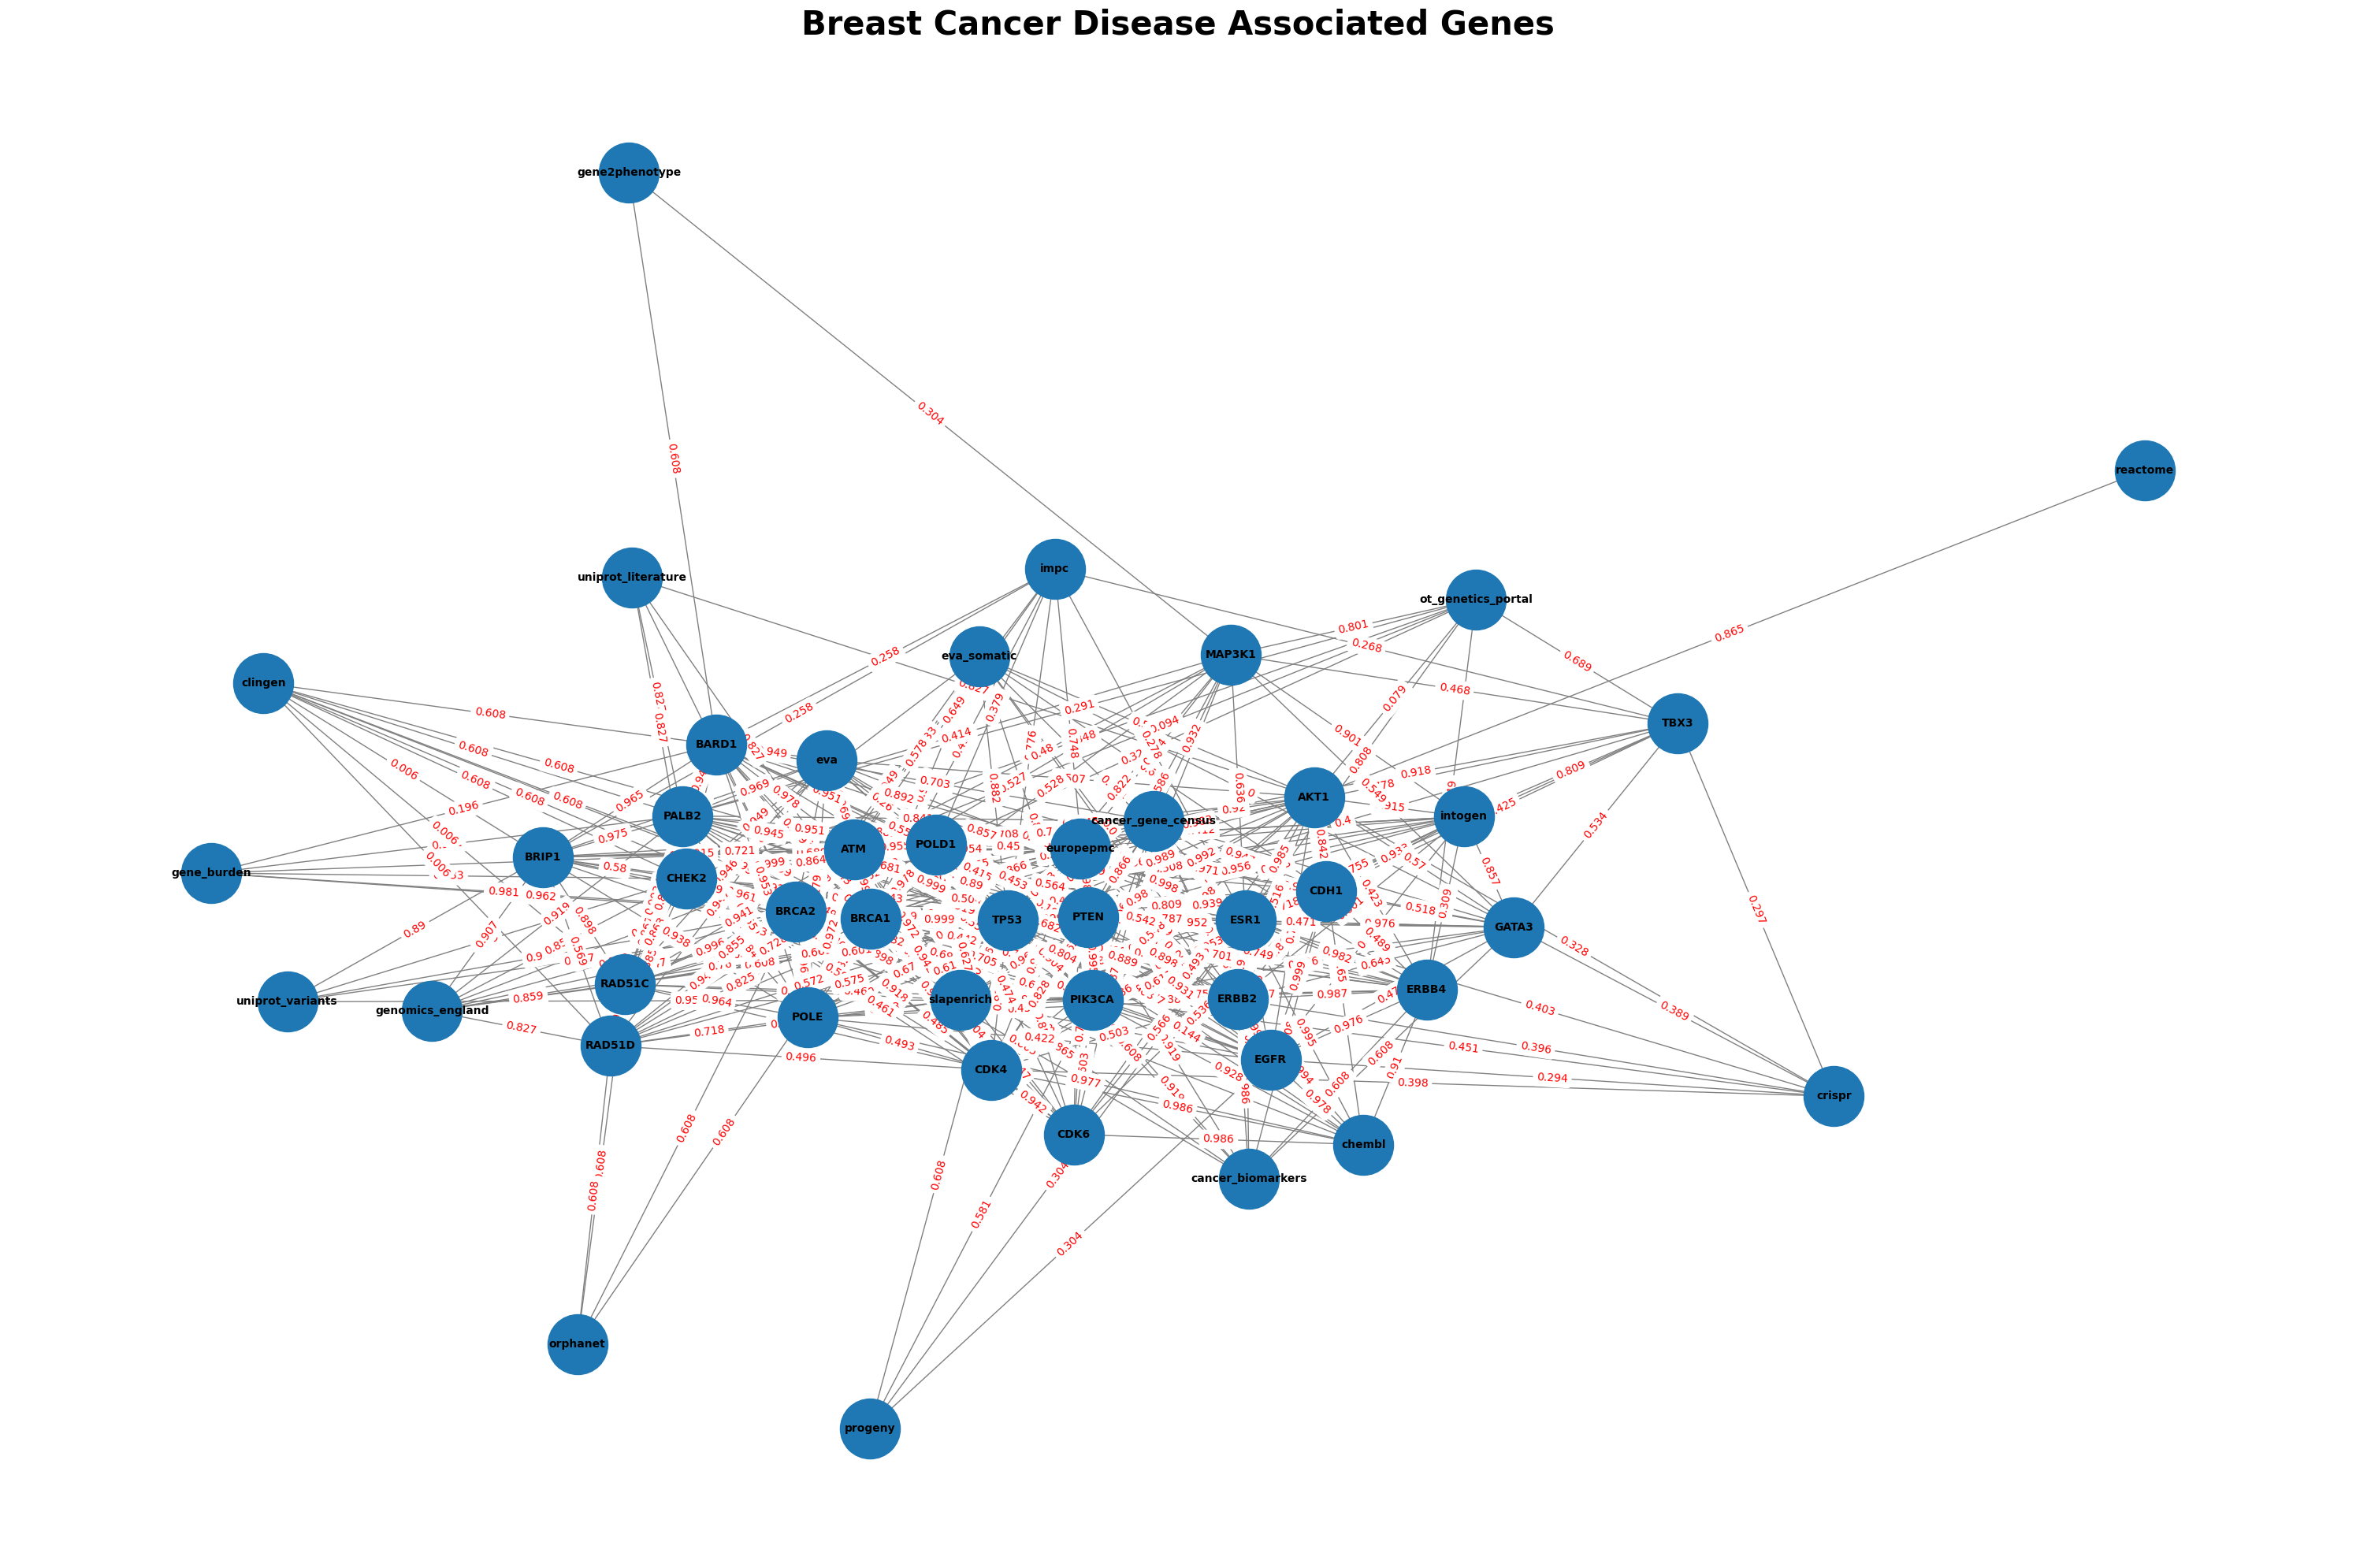

In [37]:
plt.figure(figsize=(30, 20))

pos = nx.spring_layout(G_composed, seed=42, k=0.7, iterations=90)  # Adjust 'k' and 'iterations' for better spacing

# Draw nodes with labels
nx.draw_networkx(G_composed, pos, with_labels=True, node_size=3000, font_size=10, font_weight='bold', edge_color='gray')
edge_labels = nx.get_edge_attributes(G_composed, 'weight')
nx.draw_networkx_edge_labels(G_composed, pos, edge_labels, font_color='red')

plt.axis('off')
plt.title(f"Breast Cancer Disease Associated Genes", fontsize=30, fontweight='bold')
plt.tight_layout()
# os.makedirs('assets', exist_ok=True)
# plt.savefig(f'assets/{disease_id}_{G_composed}.png')
plt.show()

_these edge attributes are preserved, and they can be accessed later using `nx.get_edge_attributes` with the specific attribute name `score` or `datasourceScores_score`_

### Method 2: Manually Adding Edges with `add_edge` and [compose](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.operators.binary.compose.html#compose)

In [38]:
G2 = nx.Graph()
for _, row in open_target_df.iterrows():
    G2.add_edge(row['datasourceScores_id'],
               row['approvedSymbol'],
               weight=row['datasourceScores_score'],
               type='disease-gene')

H2 = nx.Graph()
for _, row in STRING_df.iterrows():
    H2.add_edge(row['preferredName_A'],
               row['preferredName_B'],
               weight=row['score'],
               type='protein-protein')

In [39]:
# Merge the two graphs
G_composed2 = nx.compose(G2, H2)


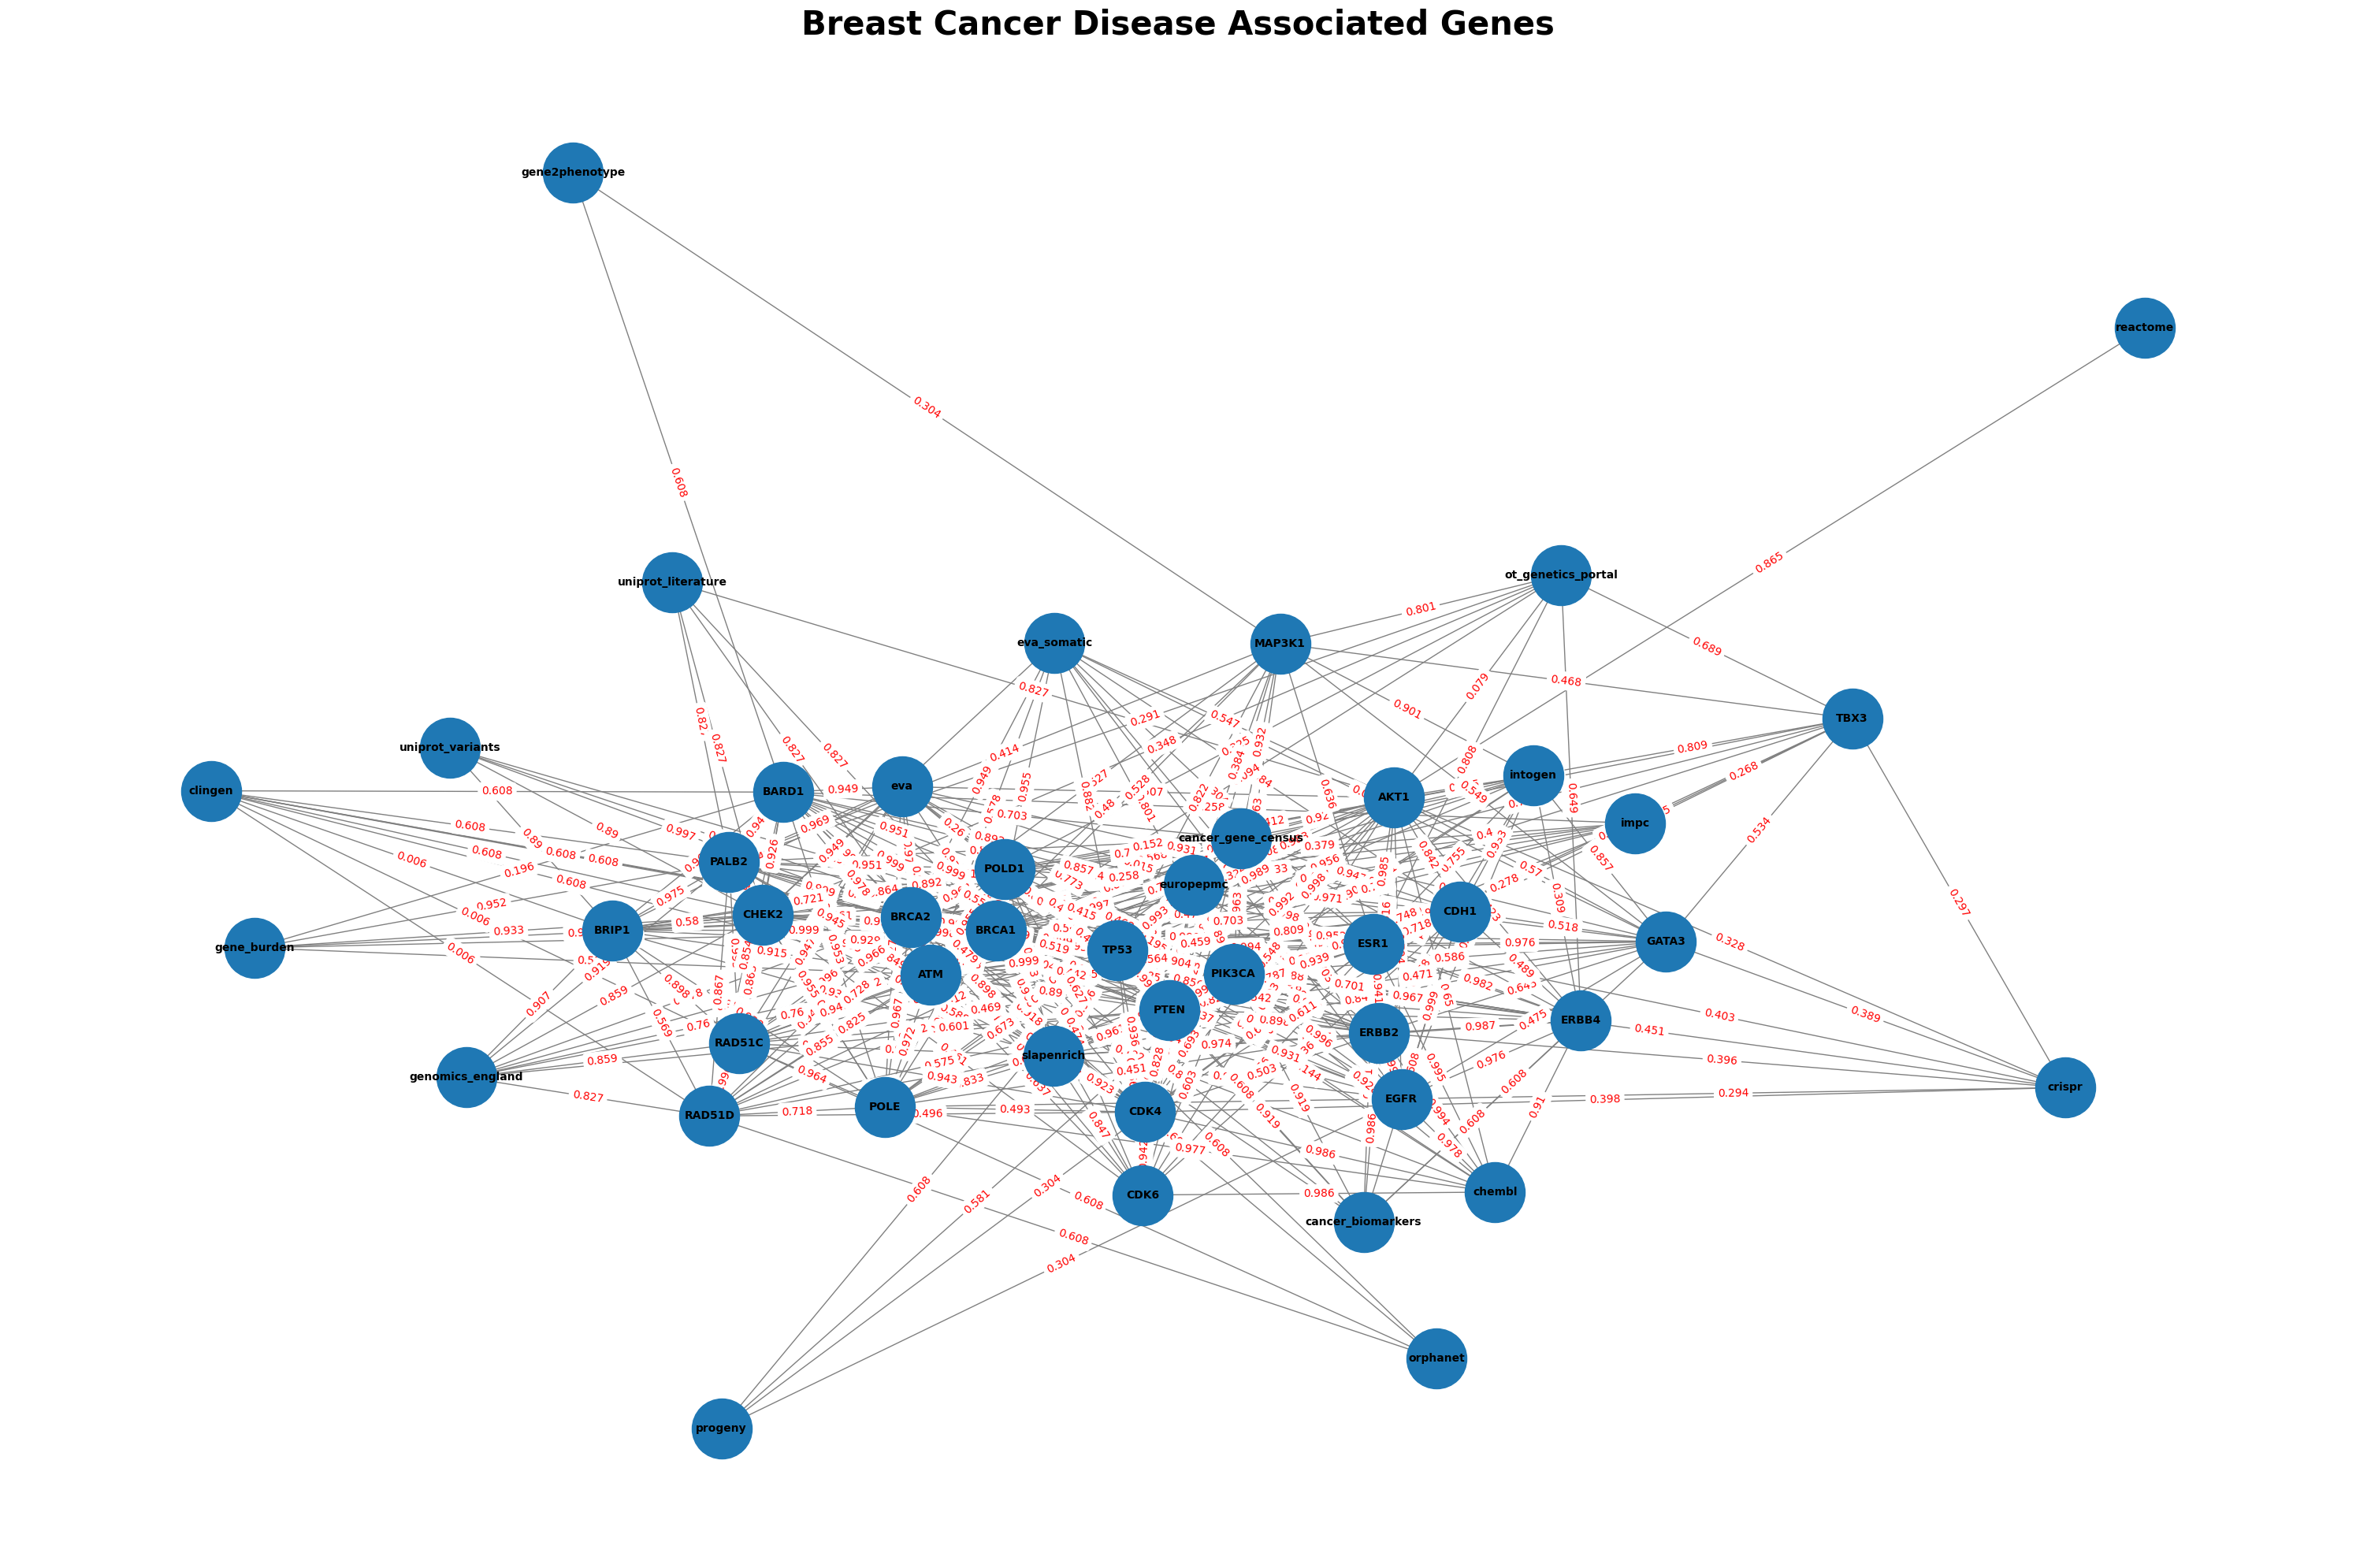

In [40]:
plt.figure(figsize=(30, 20))

pos = nx.spring_layout(G_composed2, seed=42, k=0.9, iterations=100)  # Adjust 'k' and 'iterations' for better spacing


# Draw nodes with labels
nx.draw_networkx(G_composed2, pos, with_labels=True, node_size=3000, font_size=10, font_weight='bold', edge_color='gray')

edge_labels = nx.get_edge_attributes(G_composed2, 'weight')
nx.draw_networkx_edge_labels(G_composed2, pos, edge_labels, font_color='red')

plt.axis('off')
plt.title(f"Breast Cancer Disease Associated Genes", fontsize=30, fontweight='bold')
plt.tight_layout()
# plt.savefig(f'assets/{disease_id}.png')
plt.show()


### Comparing Node Connections Across Methods

In [41]:
def get_node_edges(graph, node, edge_type=None):
    """
    Returns edges connected to specified nodes in a graph
    optionally filtered by edge type
    """
    edge_types = ['disease-gene', 'protein-protein']
    if edge_type is not None and edge_type not in edge_types:
        raise ValueError(f"Invalid edge type. Must be one of {edge_types}.")
    edges = list(graph.edges(node, data=True))
    if edge_type:
        edges = [edge for edge in edges if edge[2].get('type') == edge_type]
    return edges

def edge_to_tuple(edge):
    """Convert edge to a tuple with dictionaries as frozensets"""
    u, v, attr = edge
    attr_frozenset = frozenset(attr.items())
    return (u, v, attr_frozenset)

In [42]:
node = 'ERBB4'
edges_composed = get_node_edges(G_composed, node, edge_type='protein-protein')
edges_composed2 = get_node_edges(G_composed2, node, edge_type='protein-protein')

print(f"Edges connected to {node} in {G_composed}:")
for edge in edges_composed[:5]:
    print(edge)

print(f"\nEdges connected to {node} in {G_composed2}:")
for edge in edges_composed2[:5]:
    print(edge)

edges_composed_set = set(edge_to_tuple(edge) for edge in edges_composed)
edges_composed2_set = set(edge_to_tuple(edge) for edge in edges_composed2)
if edges_composed_set == edges_composed2_set:
    print("\nThe sets of edges are identical.")

Edges connected to ERBB4 in Graph with 45 nodes and 412 edges:
('ERBB4', 'TP53', {'weight': 0.701, 'type': 'protein-protein'})
('ERBB4', 'CDH1', {'weight': 0.489, 'type': 'protein-protein'})
('ERBB4', 'ESR1', {'weight': 0.982, 'type': 'protein-protein'})
('ERBB4', 'ERBB2', {'weight': 0.987, 'type': 'protein-protein'})
('ERBB4', 'AKT1', {'weight': 0.423, 'type': 'protein-protein'})

Edges connected to ERBB4 in Graph with 45 nodes and 412 edges:
('ERBB4', 'TP53', {'weight': 0.701, 'type': 'protein-protein'})
('ERBB4', 'CDH1', {'weight': 0.489, 'type': 'protein-protein'})
('ERBB4', 'ESR1', {'weight': 0.982, 'type': 'protein-protein'})
('ERBB4', 'ERBB2', {'weight': 0.987, 'type': 'protein-protein'})
('ERBB4', 'AKT1', {'weight': 0.423, 'type': 'protein-protein'})

The sets of edges are identical.


## Integrating Graphs and Class Definitions

In [43]:
import sys
sys.path.append('../src')
from graph_composer import GraphComposer


### Generating Graphs for Infectious Diseases

The dataset for the [Infectious Disease](https://platform.opentargets.org/disease/EFO_0005741/associations) is identified by `EFO_0005741`

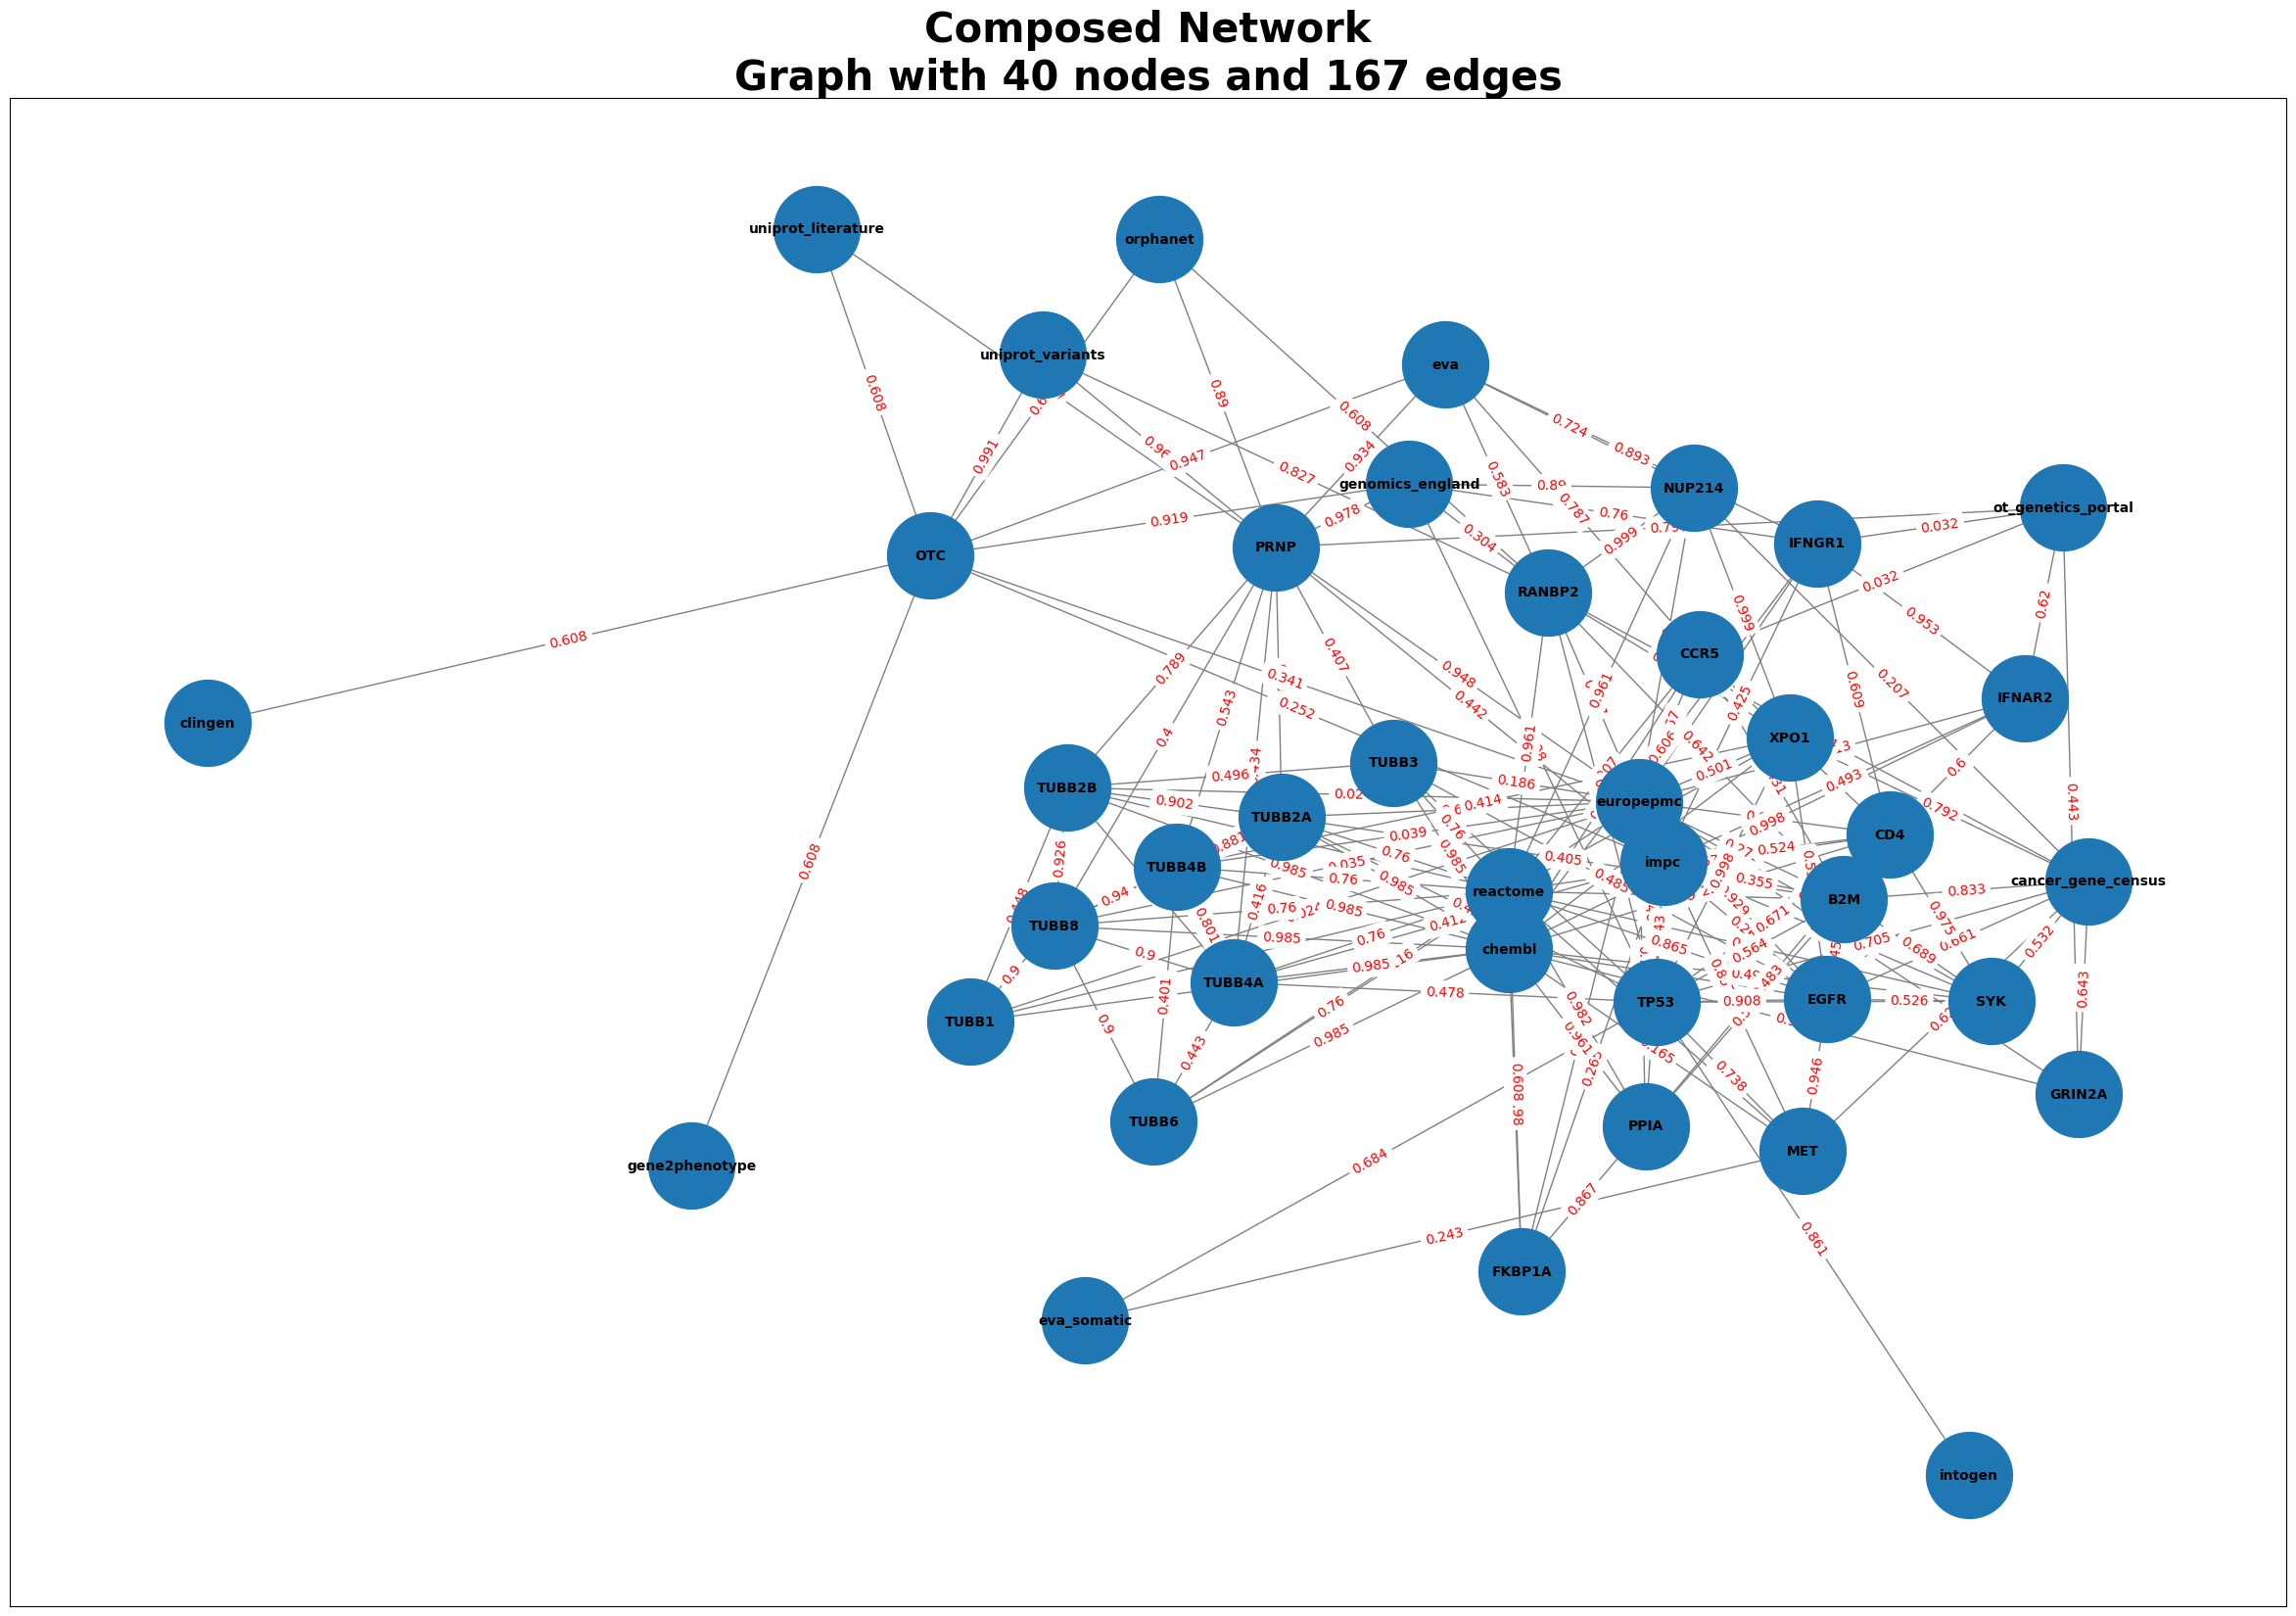

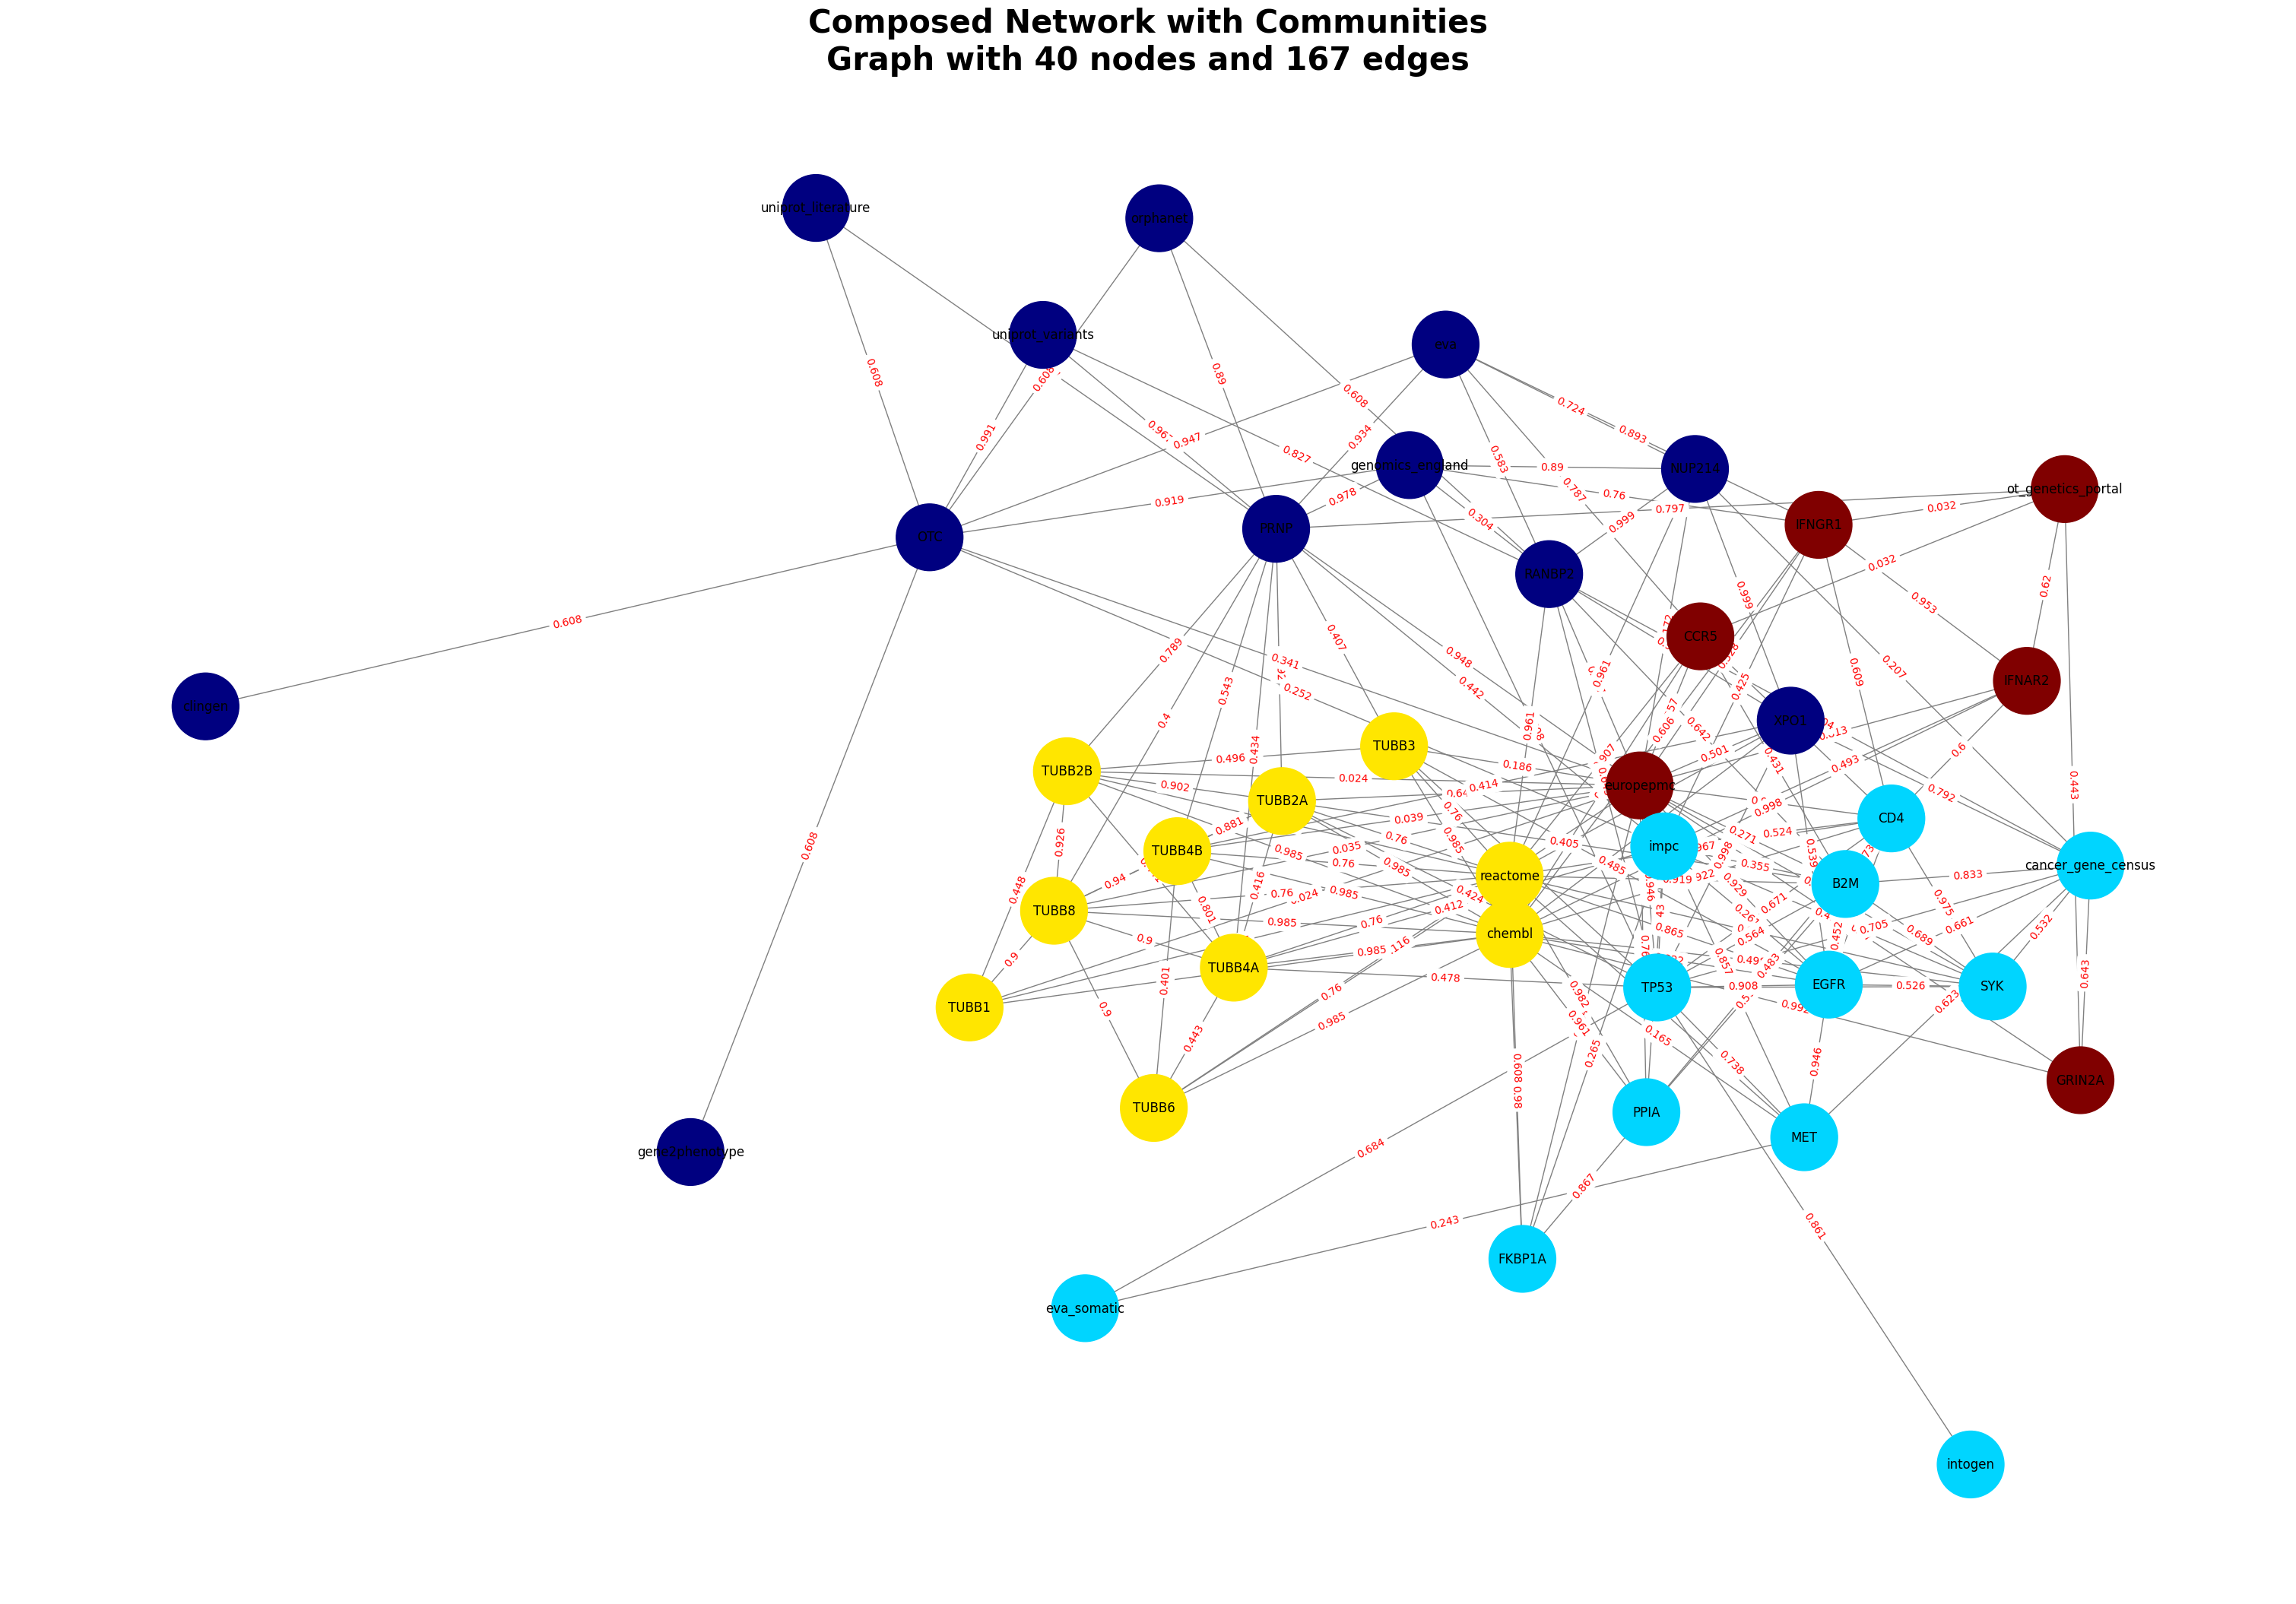

In [44]:
disease_id = "EFO_0005741"
disease_name="Infectious"
Infectious = GraphComposer(disease_id, disease_name)
Infectious.process_all(plot=True)

In [45]:
# Accessing the features, and genes
features = Infectious.features
df = Infectious.open_target_df
gene = Infectious.gene_symbols

score = get_feature_score(df, gene_symbol = 'PRNP', feature_key='orphanet')

orphanet score for PRNP: 0.89


![image](https://github.com/user-attachments/assets/7588ebee-83b5-4c39-b238-91e6e300f607)


In [46]:
merged_df = Infectious.get_merged_dataframe()
print(merged_df.describe)
print(merged_df.info())

<bound method NDFrame.describe of                source  target  weight             type
0    genomics_england    PRNP   0.978     disease-gene
1    genomics_england     OTC   0.919     disease-gene
2    genomics_england  RANBP2   0.304     disease-gene
3    genomics_england  NUP214   0.890     disease-gene
4    genomics_england    TP53   0.608     disease-gene
..                ...     ...     ...              ...
162              XPO1    EGFR   0.539  protein-protein
163              EGFR     B2M   0.452  protein-protein
164              EGFR     SYK   0.526  protein-protein
165              EGFR     MET   0.946  protein-protein
166               SYK     B2M   0.689  protein-protein

[167 rows x 4 columns]>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  167 non-null    object 
 1   target  167 non-null    object 
 2   weight  167 non-null    

In [47]:
merged_df.head()

source  target  weight          type
0  genomics_england    PRNP   0.978  disease-gene
1  genomics_england     OTC   0.919  disease-gene
2  genomics_england  RANBP2   0.304  disease-gene
3  genomics_england  NUP214   0.890  disease-gene
4  genomics_england    TP53   0.608  disease-gene

### Generating Graphs for Alzheimer’s Disease

The dataset for the [Alzheimer Disease](https://platform.opentargets.org/disease/MONDO_0004975/associations) is identified by `MONDO_0004975`

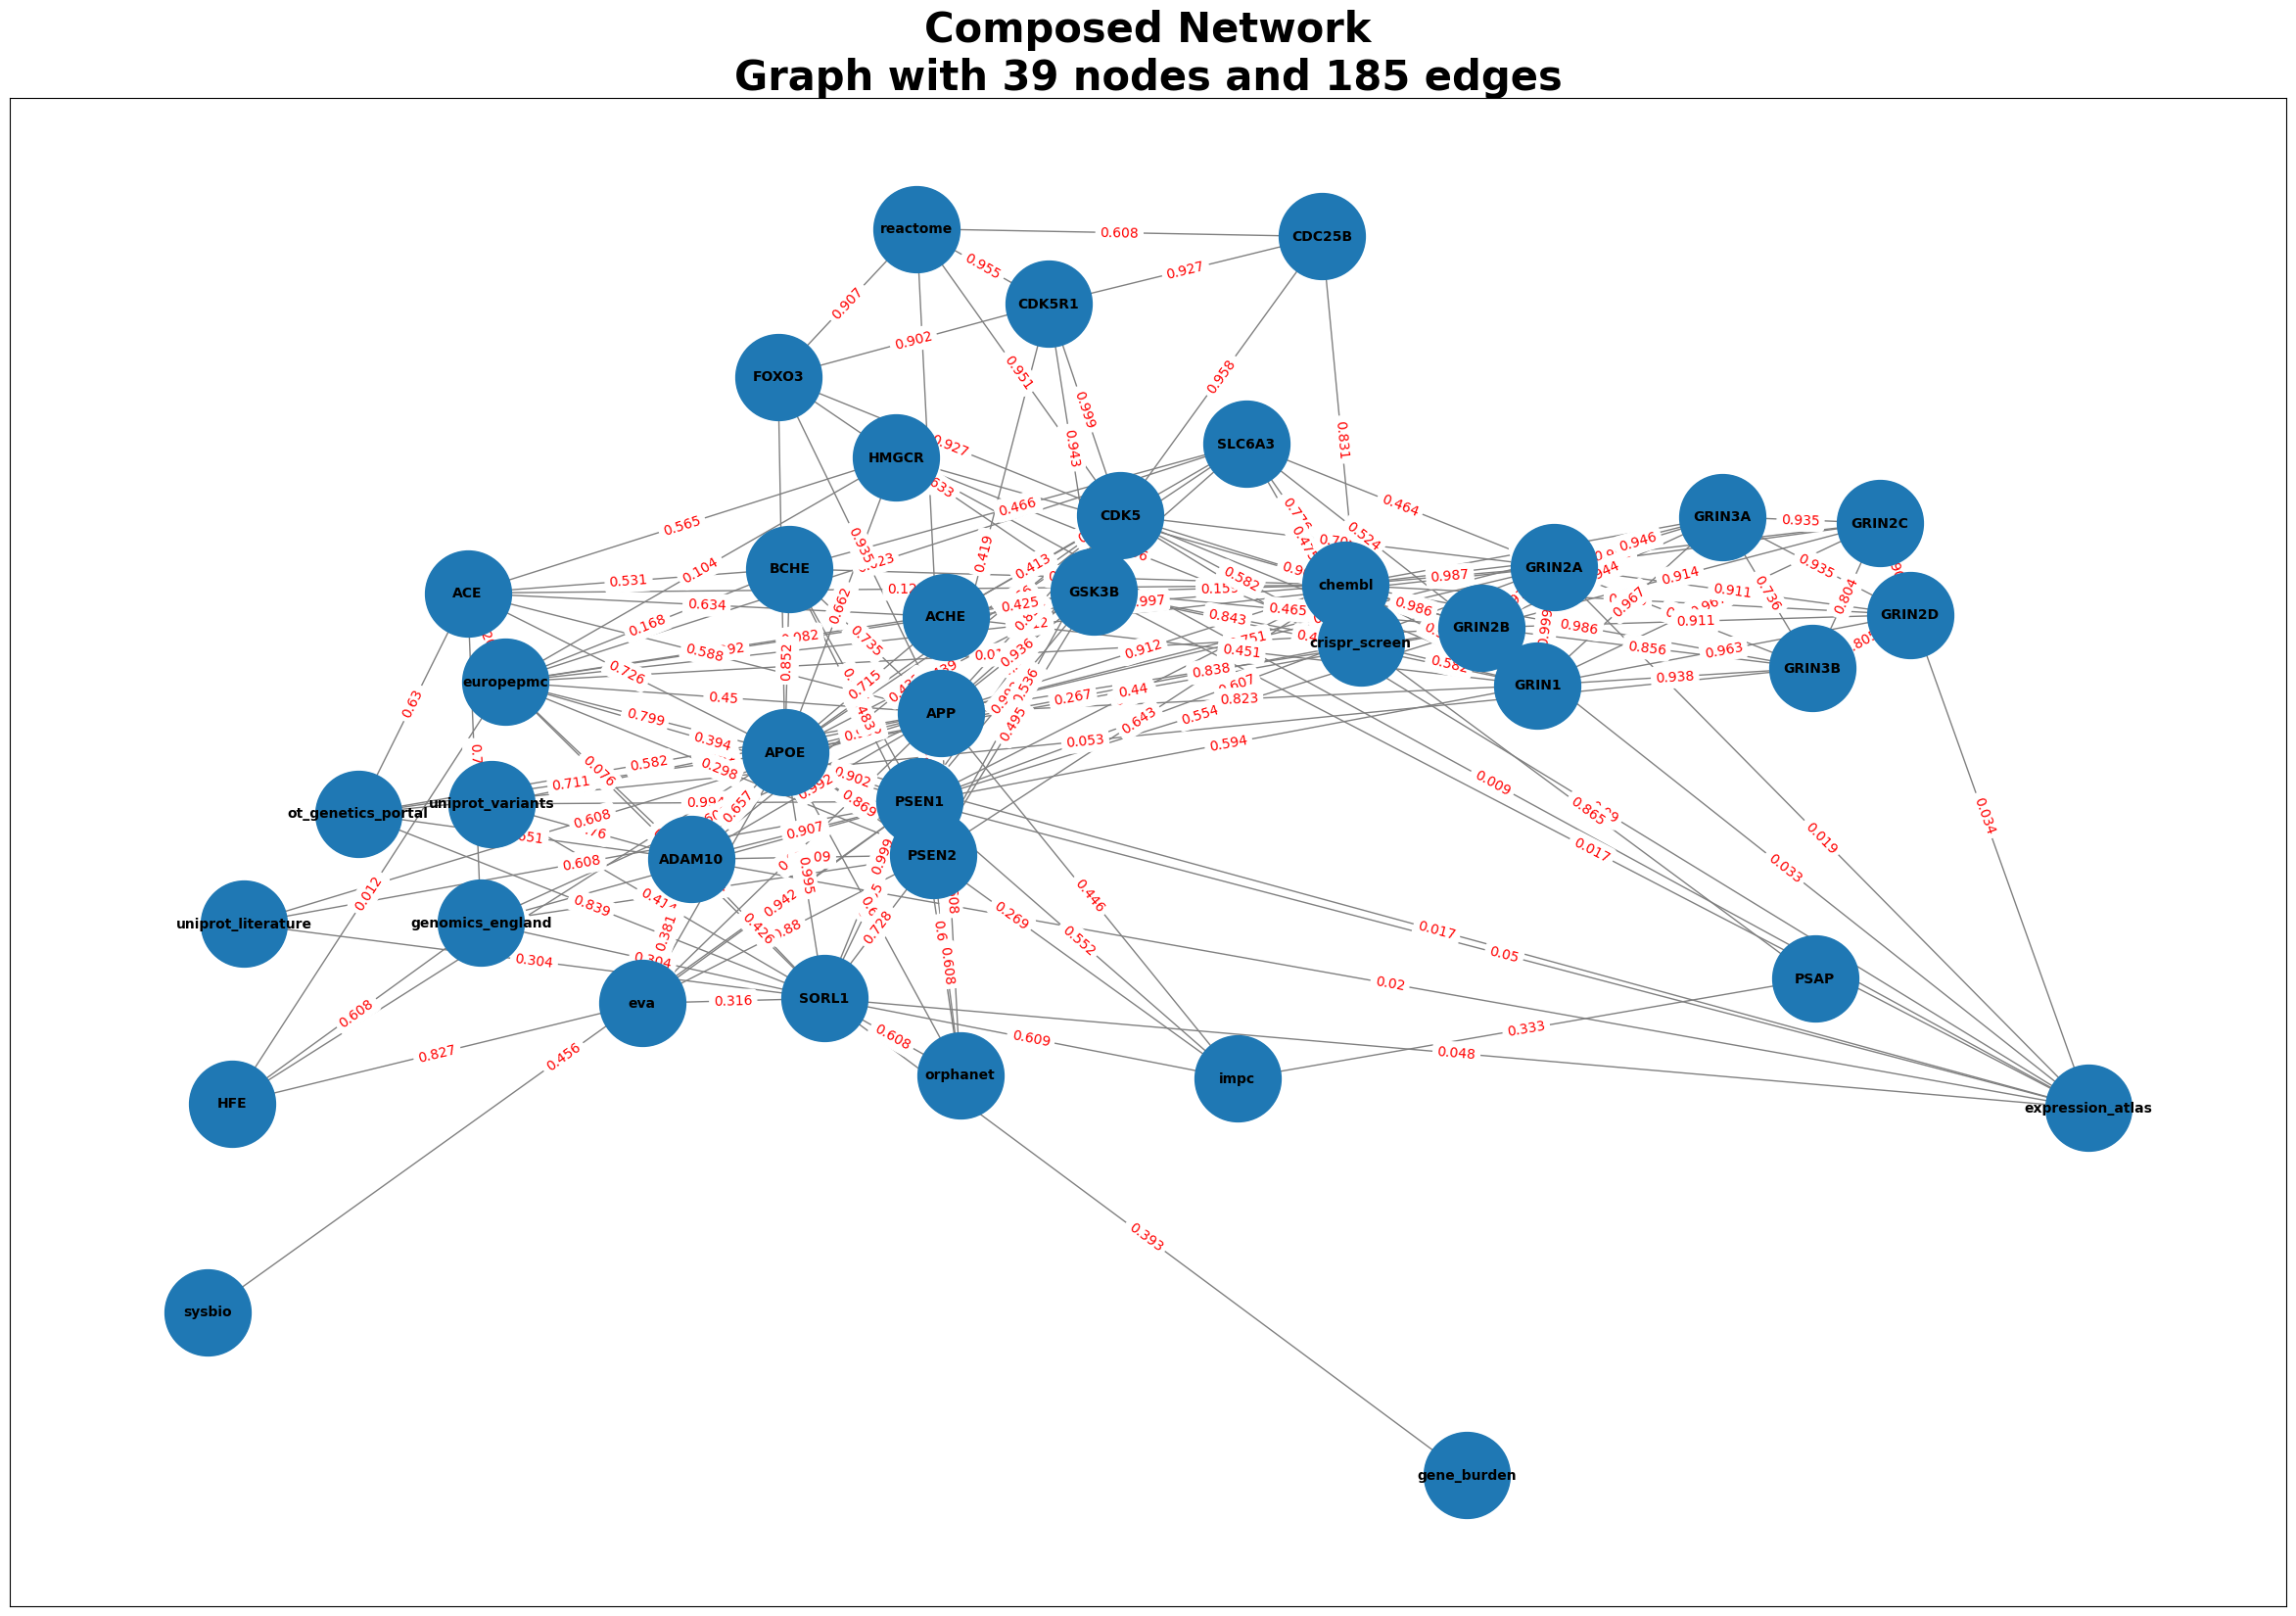

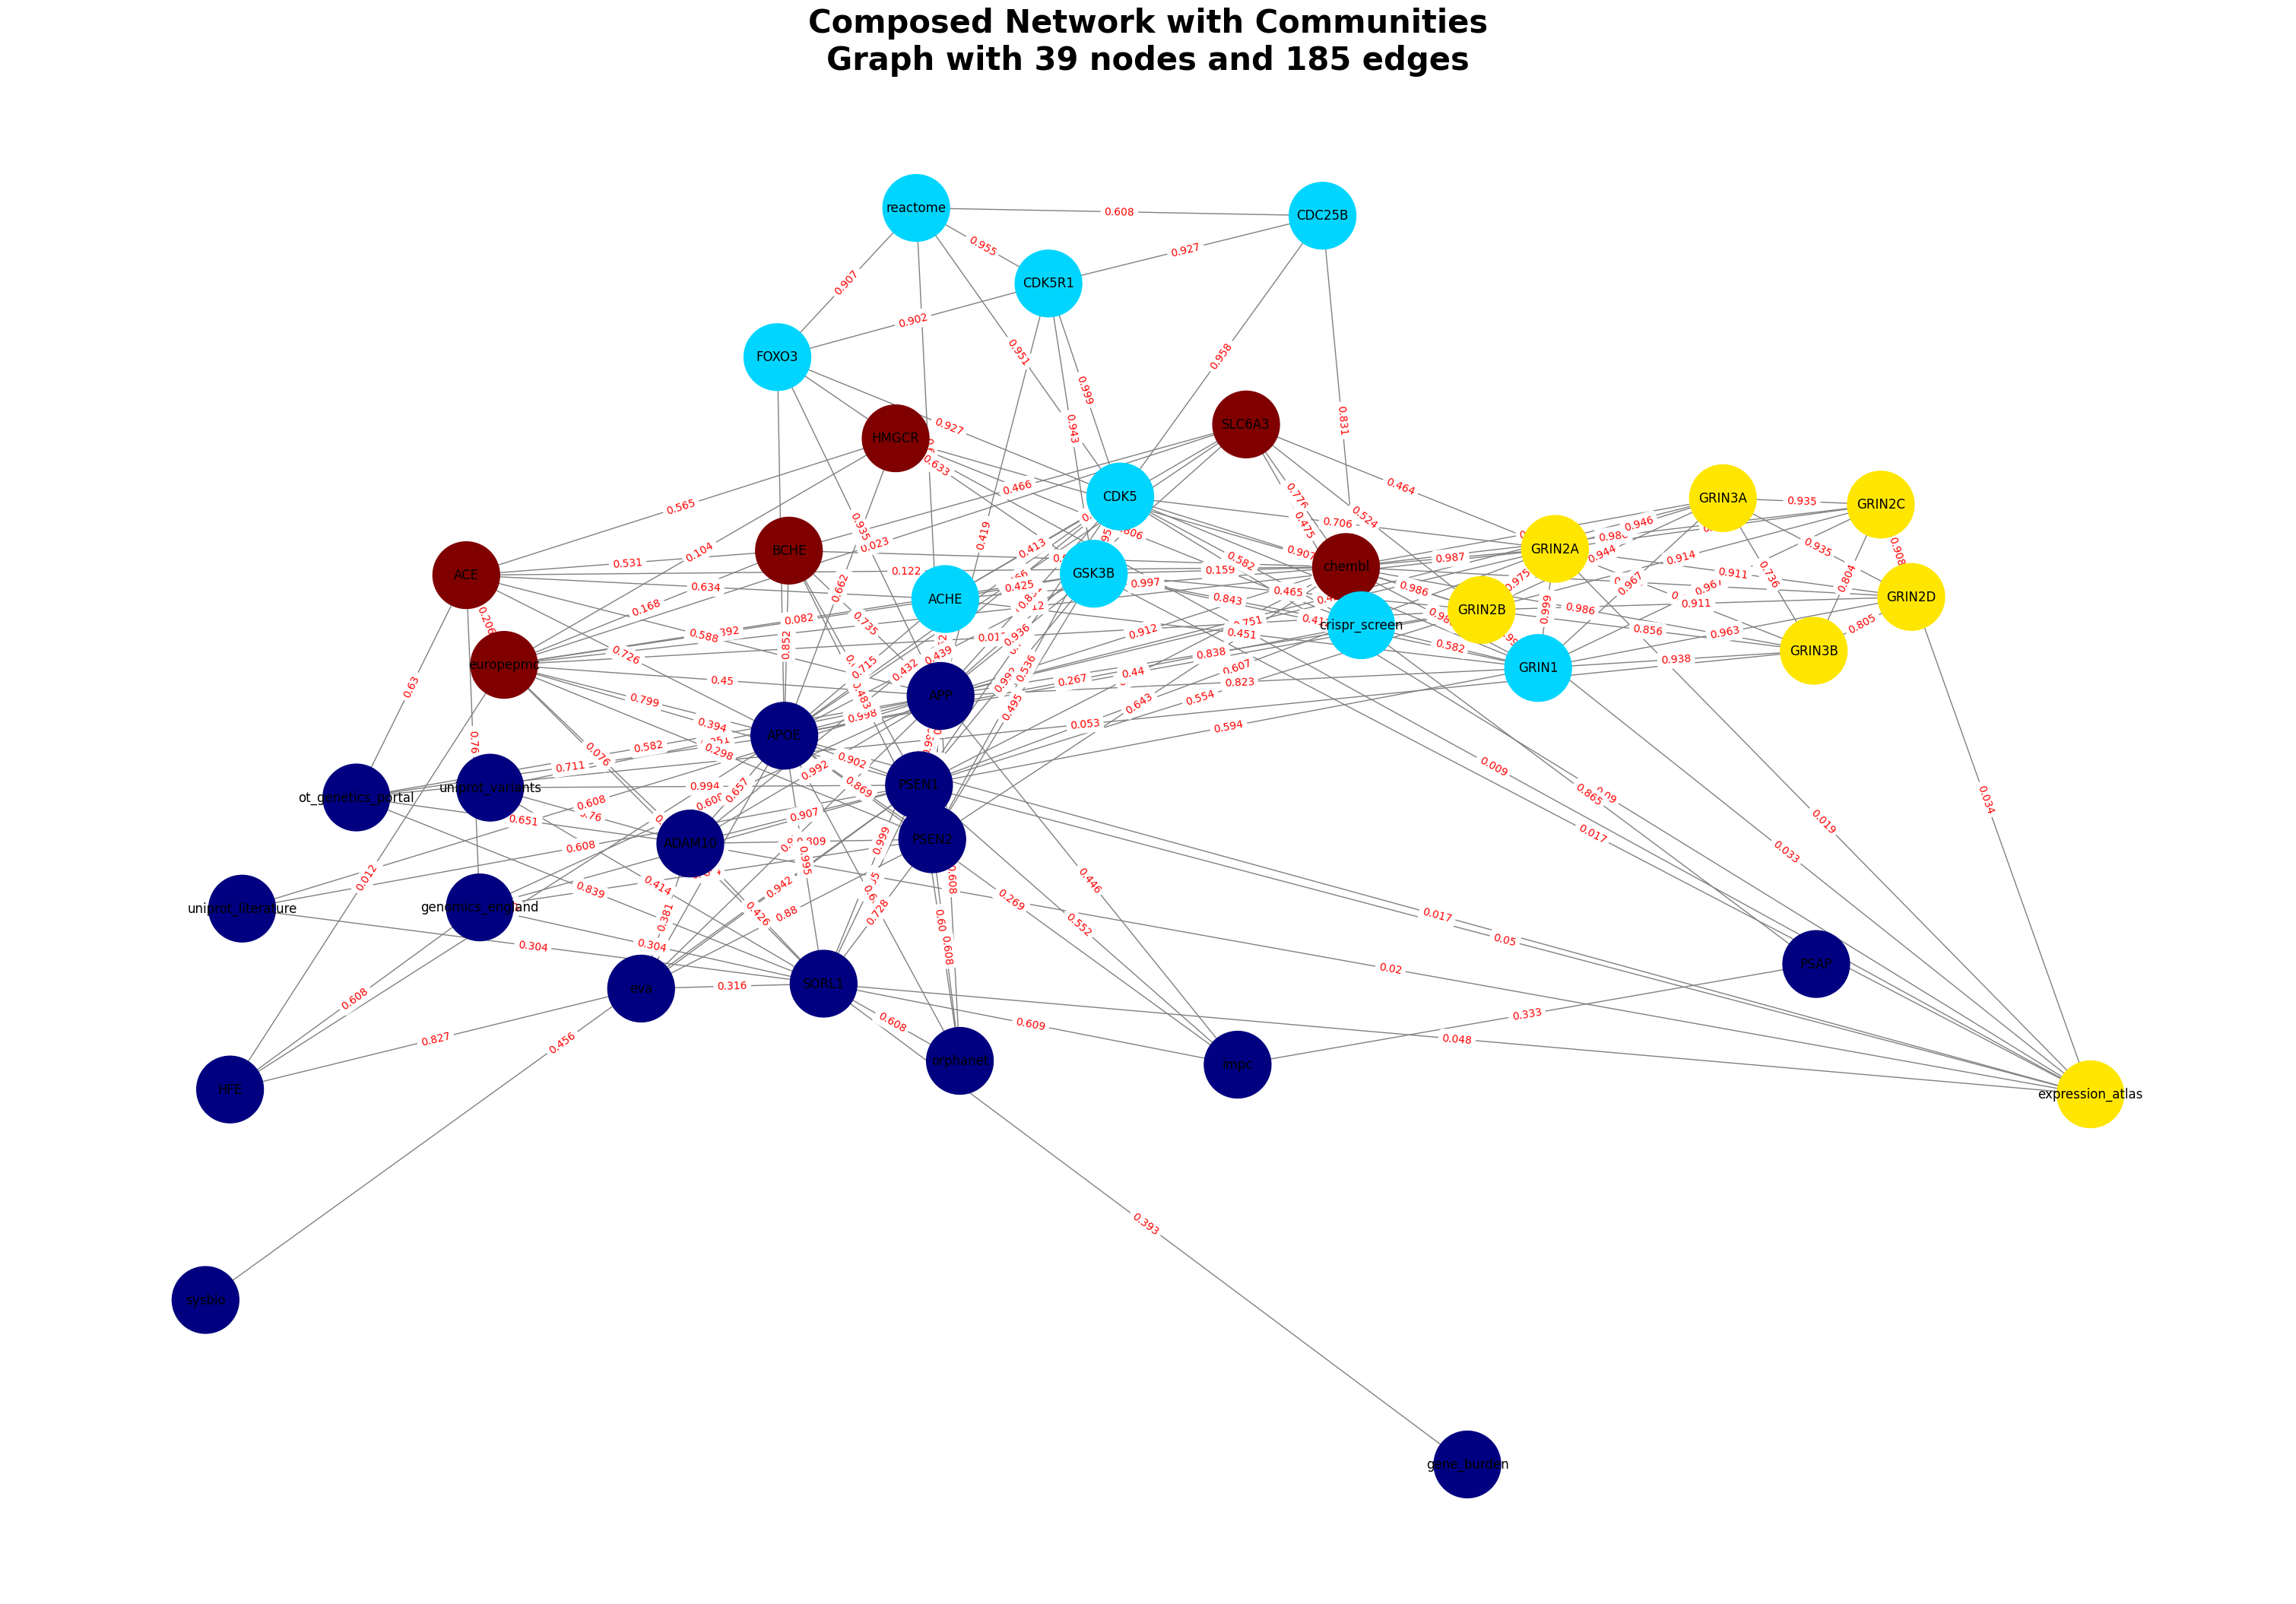

In [48]:
disease_id = "MONDO_0004975"
Alzheimer = GraphComposer(disease_id, disease_name="Alzheimer")
Alzheimer.process_all(plot=True)

In [49]:
# Accessing the merged_df
merged_df2 = Alzheimer.get_merged_dataframe()

In [50]:
merged_df2.head()

source            target  weight          type
0  uniprot_variants             PSEN1   0.994  disease-gene
1  uniprot_variants               APP   0.951  disease-gene
2  uniprot_variants             SORL1   0.414  disease-gene
3  uniprot_variants            ADAM10   0.760  disease-gene
4             PSEN1  genomics_england   0.955  disease-gene